<a href="https://colab.research.google.com/github/citizenyves/Data-Analysis-with-Statistical-Methods/blob/main/Data_Analysis_with_Statisitical_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.Problem definition
: **Which game should we develop for the next quarter?**


>지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.
>
>연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.
>
>출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.


### 1.1. Uploading Data

In [ ]:
# 파일 읽기
from google.colab import files

files.upload()

Saving vgames2.csv to vgames2.csv


{'vgames2.csv': b'"","Name","Platform","Year","Genre","Publisher","NA_Sales","EU_Sales","JP_Sales","Other_Sales"\n"1","Candace Kane\'s Candy Factory","DS","2008","Action","Destineer","0.04","0","0","0"\n"2","The Munchables","Wii","2009","Action","Namco Bandai Games","0.17","0","0","0.01"\n"3","Otome wa Oanesama Boku ni Koi Shiteru Portable","PSP","2010","Adventure","Alchemist","0","0","0.02","0"\n"4","Deal or No Deal: Special Edition","DS","2010","Misc","Zoo Games","0.04","0","0","0"\n"5","Ben 10 Ultimate Alien: Cosmic Destruction","PS3","2010","Platform","D3Publisher","0.12","0.09","0","0.04"\n"6","Power Pro Kun Pocket 8","DS","2005","Sports","Konami Digital Entertainment","0","0","0.14","0"\n"7","JASF: Jane\'s Advanced Strike Fighters","PC","2011","Simulation","Deep Silver","0.02","0.01","0","0"\n"8","Samurai Warriors: State of War","PSP","2005","Action","Tecmo Koei","0.07","0","0.11","0.01"\n"9","Imabikisou","PS3","2007","Adventure","Sega","0","0","0.04","0"\n"10","The Penguins of M

### 1.2. import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chisquare, chi2_contingency
from scipy.stats import ttest_1samp, ttest_ind

# 1.Exploratory Data Analysis (EDA)

In [ ]:
df_origin = pd.read_csv('vgames2.csv', index_col = 0)
df_origin

Name  ... Other_Sales
1                        Candace Kane's Candy Factory  ...           0
2                                      The Munchables  ...        0.01
3      Otome wa Oanesama Boku ni Koi Shiteru Portable  ...           0
4                    Deal or No Deal: Special Edition  ...           0
5           Ben 10 Ultimate Alien: Cosmic Destruction  ...        0.04
...                                               ...  ...         ...
16594                         Ice Age 2: The Meltdown  ...        0.01
16595                     Rainbow Islands: Revolution  ...           0
16596                                        NBA 2K16  ...        0.13
16597                     Toukiden: The Age of Demons  ...        0.03
16598                        The King of Fighters '95  ...        0.01

[16598 rows x 9 columns]

## 1.1. Checking data type 

In [ ]:
print(df_origin.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB
None


## 1.2. Checking missing values 

In [ ]:
print(df_origin.isnull().sum())

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64


## 1.3. Preprocessing

#### 1.3.1. Replacing string expressions with numerical one

In [ ]:
# Removing K or M string expressions in columns of each Sales by region and replacing it with a numerical unit
# ==> K = 10**3, M = 10**6

def remove_str(x):
    if 'K' in x:
        return float(x.replace('K', '')) * 1000
    elif 'M' in x:
        return float(x.replace('M', '')) * 1000000
    else:
        return float(x) * 1000000

df_origin['NA_Sales'] = df_origin['NA_Sales'].apply(remove_str)
df_origin['EU_Sales'] = df_origin['EU_Sales'].apply(remove_str)
df_origin['JP_Sales'] = df_origin['JP_Sales'].apply(remove_str)
df_origin['Other_Sales'] = df_origin['Other_Sales'].apply(remove_str)

In [ ]:
# Creating 'total_Sales' column from other's sum

df_origin['total_Sales'] = df_origin['NA_Sales'] + df_origin['EU_Sales'] + df_origin['JP_Sales'] + df_origin['Other_Sales']
df_origin.head()

Name  ... total_Sales
1                    Candace Kane's Candy Factory  ...     40000.0
2                                  The Munchables  ...    180000.0
3  Otome wa Oanesama Boku ni Koi Shiteru Portable  ...     20000.0
4                Deal or No Deal: Special Edition  ...     40000.0
5       Ben 10 Ultimate Alien: Cosmic Destruction  ...    250000.0

[5 rows x 10 columns]

#### 1.3.2. Deleting the missing values : [Two sample t-test]

In [ ]:
# Mean of total_Sales before removing missing values
mean_total_Sales_bf = np.mean(df_origin['total_Sales'])
print(f"Mean before removing missing values: {round(mean_total_Sales_bf,2)}")

Mean before removing missing values: 537164.12


In [ ]:
# Checking the percentage of the values of total_Sales column where the nulls exist in row in the entire value of total_Sales
# 결측값 있는 행의 각 total_Sales 값이 전체데이터의 total_Sales 에서 차지하는 비율 확인

# Sum of 'total_Sales'
total_Sales = df_origin['total_Sales'].sum()

# Sum of the values in column 'total_Sales' for rows where nulls in column 'Year' exist
null_Year = df_origin[df_origin['Year'].isnull()]
null_Year_Sales = null_Year['total_Sales'].sum()

# Sum of the values in column 'total_Sales' for rows where nulls in column 'Genre' exist
null_Genre = df_origin[df_origin['Genre'].isnull()]
null_Genre_Sales = null_Genre['total_Sales'].sum()

# Sum of the values in column 'total_Sales' for rows where nulls in column 'Publisher' exist
null_Publisher = df_origin[df_origin['Publisher'].isnull()]
null_Publisher_Sales = null_Publisher['total_Sales'].sum()

# Percentages of each
percent_Year = (null_Year_Sales / total_Sales) * 100
percent_Genre = (null_Genre_Sales / total_Sales) * 100
percent_Publisher = (null_Publisher_Sales / total_Sales) * 100

print(f"for 'Year' col, the share of missing values: {round(percent_Year,2)}%")
print(f"for 'Genre' col, the share of missing values: {round(percent_Genre,2)}%")
print(f"for 'Publisher' col, the share of missing values: {round(percent_Publisher,2)}%")

for 'Year' col, the share of missing values: 1.12%
for 'Genre' col, the share of missing values: 0.58%
for 'Publisher' col, the share of missing values: 0.17%


The each percentage is too small to impact on the entire data. <br>
So, I decided to drop all rows with missing values.

In [ ]:
# Removing all rows including missing values ==> 357 rows removed in total
df = df_origin.dropna(axis=0, how='any')

Also, the p-value from two sample t-test is quite high(0.91), which means that the two mean values before and after removing missing values have little difference.

In [ ]:
# Mean of total_Sales after removing missing values
mean_total_Sales_af = np.mean(df['total_Sales'])
print(f"Mean before removing missing values: {round(mean_total_Sales_bf,2)}")
print(f"Mean after removing missing values: {round(mean_total_Sales_af,2)}")

# Two Sample T-test - Comparing Mean of total_Sales before removing missing values and the one after
# ==> We cannot reject the null hypothesis(the means from the two sample are likely to be same)
print("\n")
print(f"Statistic: {ttest_ind(df_origin['total_Sales'], df['total_Sales'])[0]}")
print(f"Pvalue: {ttest_ind(df_origin['total_Sales'], df['total_Sales'])[1]}")

Mean before removing missing values: 537164.12
Mean after removing missing values: 539090.57


Statistic: -0.11192241770225524
Pvalue: 0.9108856056216931


#### 1.3.3. Additional preprocessing

In [ ]:
df.head()

Name  ... total_Sales
1                    Candace Kane's Candy Factory  ...     40000.0
2                                  The Munchables  ...    180000.0
3  Otome wa Oanesama Boku ni Koi Shiteru Portable  ...     20000.0
4                Deal or No Deal: Special Edition  ...     40000.0
5       Ben 10 Ultimate Alien: Cosmic Destruction  ...    250000.0

[5 rows x 10 columns]

In [ ]:
# for column 'Year', changing data type from float to int
df['Year'] = df['Year'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# for column 'Year', unifying the data in different expressions into some consistent expressions
change_value_dict = {0:2000, 1:2001, 2:2002, 3:2003, 4:2004, 5:2005, 6:2006, 7:2007, 8:2008, 9:2009,
                     10:2010, 11:2011, 12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 86:1986, 94:1994,
                     95:1995, 96:1996, 97:1997, 98:1998}

# using replace with dictionnary
df = df.replace({'Year' : change_value_dict})

In [ ]:
df['Year'] = df['Year'].astype(str)

In [ ]:
df_year_cnt = df['Year'].value_counts().rename_axis('Year').reset_index(name='counts')
df_year_cnt = df_year_cnt.sort_values(by=['Year'], ascending=True)
df_year_cnt = df_year_cnt.reset_index().drop(columns='index')

In [ ]:
df_year_cnt

Year  counts
0   1980       8
1   1981      46
2   1982      36
3   1983      17
4   1984      14
5   1985      14
6   1986      21
7   1987      16
8   1988      15
9   1989      17
10  1990      16
11  1991      41
12  1992      43
13  1993      60
14  1994     121
15  1995     219
16  1996     262
17  1997     289
18  1998     377
19  1999     336
20  2000     348
21  2001     480
22  2002     826
23  2003     774
24  2004     740
25  2005     934
26  2006    1005
27  2007    1195
28  2008    1423
29  2009    1428
30  2010    1253
31  2011    1133
32  2012     652
33  2013     545
34  2014     580
35  2015     611
36  2016     342
37  2017       3
38  2020       1

In [ ]:
df_5year_cnt = df_year_cnt.copy()
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['1980','1981','1982','1983','1984'],"1980-1984")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['1985','1986','1987','1988','1989'],"1985-1989")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['1990','1991','1992','1993','1994'],"1990-1994")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['1995','1996','1997','1998','1999'],"1995-1999")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['2000','2001','2002','2003','2004'],"2000-2004")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['2005','2006','2007','2008','2009'],"2005-2009")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['2010','2011','2012','2013','2014'],"2010-2014")
df_5year_cnt['Year'] = df_5year_cnt['Year'].replace(['2015','2016','2017','2018','2019','2020'],"2015-2020")

df_5year_cnt = df_5year_cnt.groupby(by=['Year']).sum().reset_index()

In [ ]:
df_5year_cnt

Year  counts
0  1980-1984     121
1  1985-1989      83
2  1990-1994     281
3  1995-1999    1483
4  2000-2004    3168
5  2005-2009    5985
6  2010-2014    4163
7  2015-2020     957

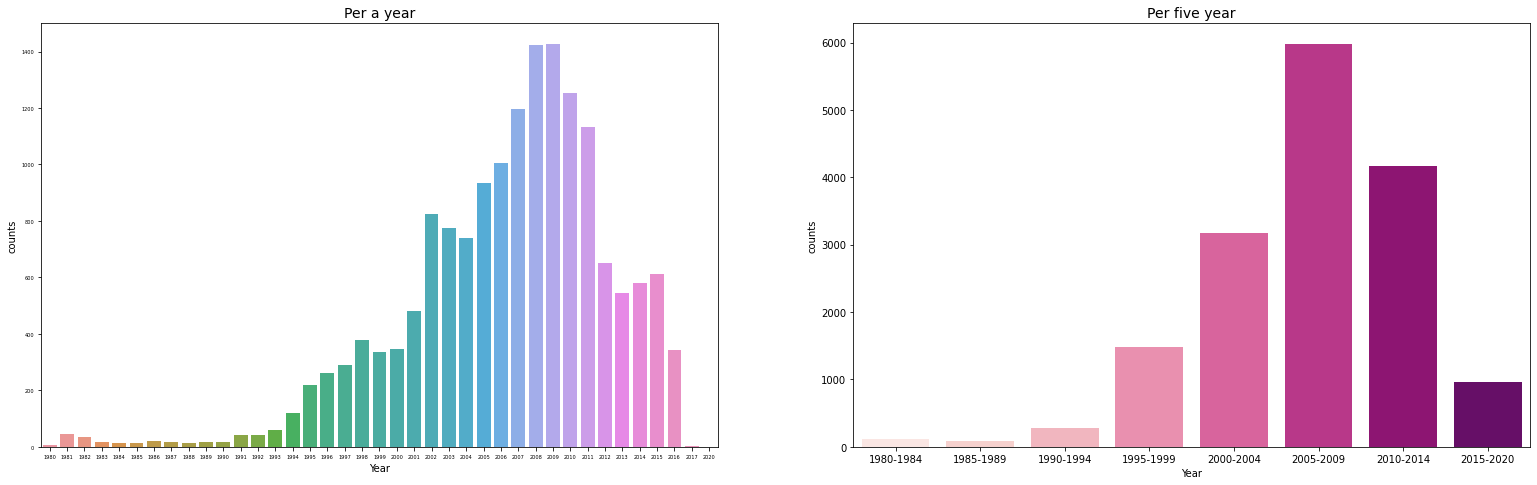

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22,6))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=None, hspace=0.2)
ax = axs.flatten()

sns.barplot(x='Year', y='counts', data=df_year_cnt, ax=ax[0])
ax[0].set_title("Per a year", fontsize=14)
ax[0].tick_params(labelsize=5)

sns.barplot(x='Year', y='counts', data=df_5year_cnt, ax=ax[1], palette='RdPu')
ax[1].set_title("Per five year", fontsize=14)
ax[1].tick_params(labelsize=10)

plt.show();

In [ ]:
# binding each year per five
df['Year'] = df['Year'].replace(['1980','1981','1982','1983','1984'],"1980-1984")
df['Year'] = df['Year'].replace(['1985','1986','1987','1988','1989'],"1985-1989")
df['Year'] = df['Year'].replace(['1990','1991','1992','1993','1994'],"1990-1994")
df['Year'] = df['Year'].replace(['1995','1996','1997','1998','1999'],"1995-1999")
df['Year'] = df['Year'].replace(['2000','2001','2002','2003','2004'],"2000-2004")
df['Year'] = df['Year'].replace(['2005','2006','2007','2008','2009'],"2005-2009")
df['Year'] = df['Year'].replace(['2010','2011','2012','2013','2014'],"2010-2014")
df['Year'] = df['Year'].replace(['2015','2016','2017','2018','2019','2020'],"2015-2020")

In [ ]:
# for columns with 'Sales', modifying the data in units of 10,000
df['NA_Sales'] = df['NA_Sales'] / 10000
df['EU_Sales'] = df['EU_Sales'] / 10000
df['JP_Sales'] = df['JP_Sales'] / 10000
df['Other_Sales'] = df['Other_Sales'] / 10000
df['total_Sales'] = df['total_Sales'] / 10000

df.head()

Name  ... total_Sales
1                    Candace Kane's Candy Factory  ...         4.0
2                                  The Munchables  ...        18.0
3  Otome wa Oanesama Boku ni Koi Shiteru Portable  ...         2.0
4                Deal or No Deal: Special Edition  ...         4.0
5       Ben 10 Ultimate Alien: Cosmic Destruction  ...        25.0

[5 rows x 10 columns]

## 1.4. Handling outliers 

Quantile 메서드를 활용하여 Sales 데이터분포를 확인한다.
- 하위 75%의 값들은 크기의 차이가 미미하다.
- 상위 25% 이상의 값과 하위 75% 이하의 값들의 편차가 크다.
<br> => 박스플롯의 형태가 다소 비정상적으로 보인다.


In [ ]:
# Quantiles for checking the distribution of sales data
quantiles = [0.25, 0.50, 0.75, 1.0]

def quantile(data, col1, col2, col3, col4, col5):
    Q1_1, Q1_2, Q1_3, Q1_4 = np.quantile(data[col1], quantiles)
    Q2_1, Q2_2, Q2_3, Q2_4 = np.quantile(data[col2], quantiles)
    Q3_1, Q3_2, Q3_3, Q3_4 = np.quantile(data[col3], quantiles)
    Q4_1, Q4_2, Q4_3, Q4_4 = np.quantile(data[col4], quantiles)
    Q5_1, Q5_2, Q5_3, Q5_4 = np.quantile(data[col5], quantiles)
    
    df = pd.DataFrame(data={'quantile':["Q1", "Q2", "Q3","Q4"],
                            col1:[Q1_1, Q1_2, Q1_3, Q1_4],
                            col2:[Q2_1, Q2_2, Q2_3, Q2_4],
                            col3:[Q3_1, Q3_2, Q3_3, Q3_4],
                            col4:[Q4_1, Q4_2, Q4_3, Q4_4],
                            col5:[Q5_1, Q5_2, Q5_3, Q5_4]}
                      )

    return df.set_index('quantile')

quantile(df, 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'total_Sales')

NA_Sales  EU_Sales  JP_Sales  Other_Sales  total_Sales
quantile                                                        
Q1             0.0       0.0       0.0          0.0          6.0
Q2             8.0       2.0       0.0          1.0         17.0
Q3            24.0      11.0       4.0          4.0         48.0
Q4          4149.0    2902.0    1022.0       1057.0       8274.0

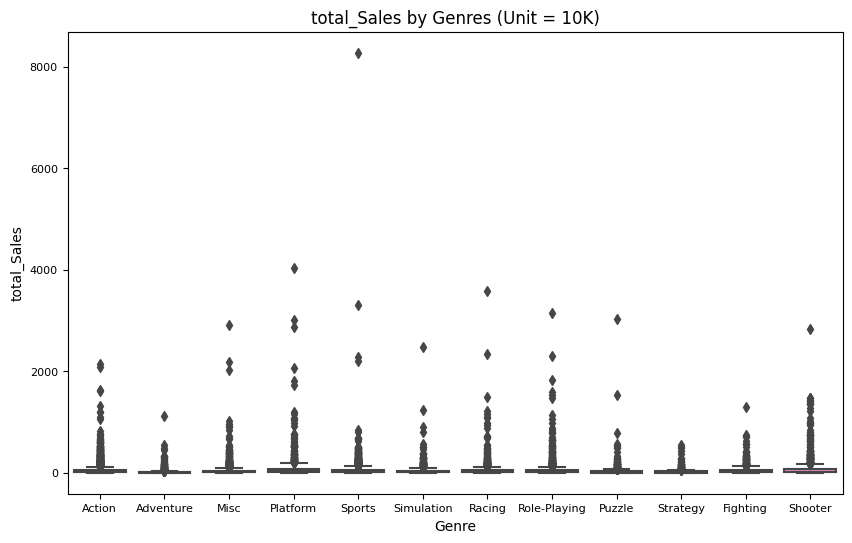

In [ ]:
# A boxplot by 'Genre' and 'total_Sales'
plt.style.use('default')
plt.rcParams['figure.figsize'] = [10, 6]
plt.title("total_Sales by Genres (Unit = 10K)")
plot = sns.boxplot(x='Genre', y='total_Sales', data=df)
plot.tick_params(labelsize=8)

plt.show()

전체 데이터에 영향을 주지 않는 선에서 Sales 상위 데이터를 이상치로 간주하고 제거하기로 한다.
- 1) 1500 이상의 값들을 이상치로 정의
- 2) 1000 이상의 값들을 이상치로 정의 <br>
==> 비교

In [ ]:
pct_Action_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Action')].index)/len(df)*100,3)
num_Action_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Action')].index))

pct_Adventure_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Adventure')].index)/len(df)*100,3)
num_Adventure_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Adventure')].index))

pct_Misc_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Misc')].index)/len(df)*100,3)
num_Misc_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Misc')].index))

pct_Platform_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Platform')].index)/len(df)*100,3)
num_Platform_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Platform')].index))

pct_Sports_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Sports')].index)/len(df)*100,3)
num_Sports_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Sports')].index))

pct_Simulation_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Simulation')].index)/len(df)*100,3)
num_Simulation_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Simulation')].index))

pct_Racing_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Racing')].index)/len(df)*100,3)
num_Racing_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Racing')].index))

pct_RP_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Role-Playing')].index)/len(df)*100,3)
num_RP_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Role-Playing')].index))

pct_puzzle_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Puzzle')].index)/len(df)*100,3)
num_puzzle_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Puzzle')].index))

pct_Strategy_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Strategy')].index)/len(df)*100,3)
num_Strategy_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Strategy')].index))

pct_Fighting_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Fighting')].index)/len(df)*100,3)
num_Fighting_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Fighting')].index))

pct_Shooter_1500 = round(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Shooter')].index)/len(df)*100,3)
num_Shooter_1500 = int(len(df[(df['total_Sales'] >= 1500.0) & (df['Genre'] == 'Shooter')].index))

dict_outlier_1500 = {" ":["number_over_1500", "share_over_1500"],
                     "Action":[int(num_Action_1500), pct_Action_1500],
                     "Adventure":[int(num_Adventure_1500), pct_Adventure_1500],
                     "Misc":[int(num_Misc_1500), pct_Misc_1500],
                     "Platform":[int(num_Platform_1500), pct_Platform_1500],
                     "Sports":[int(num_Sports_1500), pct_Sports_1500],
                     "Simulation":[int(num_Simulation_1500), pct_Simulation_1500],
                     "Racing":[int(num_Racing_1500), pct_Racing_1500],
                     "Role-Playing":[int(num_RP_1500), pct_Racing_1500],
                     "Puzzle":[int(num_puzzle_1500), pct_puzzle_1500],
                     "Starategy":[int(num_Strategy_1500), pct_Strategy_1500],
                     "Fighting":[int(num_Fighting_1500), pct_Fighting_1500],
                     "Shooter":[int(num_Shooter_1500), pct_Shooter_1500],
                    }

df_outlier_1500 = pd.DataFrame(data=dict_outlier_1500).set_index(" ")
df_outlier_1500['Total'] = df_outlier_1500.sum(axis=1)

In [ ]:
pct_Action_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Action')].index)/len(df)*100,3)
num_Action_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Action')].index))

pct_Adventure_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Adventure')].index)/len(df)*100,3)
num_Adventure_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Adventure')].index))

pct_Misc_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Misc')].index)/len(df)*100,3)
num_Misc_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Misc')].index))

pct_Platform_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Platform')].index)/len(df)*100,3)
num_Platform_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Platform')].index))

pct_Sports_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Sports')].index)/len(df)*100,3)
num_Sports_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Sports')].index))

pct_Simulation_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Simulation')].index)/len(df)*100,3)
num_Simulation_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Simulation')].index))

pct_Racing_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Racing')].index)/len(df)*100,3)
num_Racing_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Racing')].index))

pct_RP_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Role-Playing')].index)/len(df)*100,3)
num_RP_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Role-Playing')].index))

pct_puzzle_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Puzzle')].index)/len(df)*100,3)
num_puzzle_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Puzzle')].index))

pct_Strategy_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Strategy')].index)/len(df)*100,3)
num_Strategy_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Strategy')].index))

pct_Fighting_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Fighting')].index)/len(df)*100,3)
num_Fighting_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Fighting')].index))

pct_Shooter_1000 = round(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Shooter')].index)/len(df)*100,3)
num_Shooter_1000 = int(len(df[(df['total_Sales'] >= 1000.0) & (df['Genre'] == 'Shooter')].index))

dict_outlier_1000 = {" ":["number_over_1000", "share_over_1000"],
                     "Action":[int(num_Action_1000), pct_Action_1000],
                     "Adventure":[int(num_Adventure_1000), pct_Adventure_1000],
                     "Misc":[int(num_Misc_1000), pct_Misc_1000],
                     "Platform":[int(num_Platform_1000), pct_Platform_1000],
                     "Sports":[int(num_Sports_1000), pct_Sports_1000],
                     "Simulation":[int(num_Simulation_1000), pct_Simulation_1000],
                     "Racing":[int(num_Racing_1000), pct_Racing_1000],
                     "Role-Playing":[int(num_RP_1000), pct_Racing_1000],
                     "Puzzle":[int(num_puzzle_1000), pct_puzzle_1000],
                     "Starategy":[int(num_Strategy_1000), pct_Strategy_1000],
                     "Fighting":[int(num_Fighting_1000), pct_Fighting_1000],
                     "Shooter":[int(num_Shooter_1000), pct_Shooter_1000],
                    }

df_outlier_1000 = pd.DataFrame(data=dict_outlier_1000).set_index(" ")
df_outlier_1000['Total'] = df_outlier_1000.sum(axis=1)

In [ ]:
df_outlier_1500

Action  Adventure   Misc  ...  Fighting  Shooter   Total
                                            ...                           
number_over_1500   4.000        0.0  3.000  ...       0.0    1.000  28.000
share_over_1500    0.025        0.0  0.018  ...       0.0    0.006   0.153

[2 rows x 13 columns]

In [ ]:
df_outlier_1000

Action  Adventure   Misc  ...  Fighting  Shooter   Total
                                            ...                           
number_over_1000   9.000      1.000  4.000  ...     1.000   12.000  61.000
share_over_1000    0.055      0.006  0.025  ...     0.006    0.074   0.369

[2 rows x 13 columns]

In [ ]:
indexes_outlier_1500 = df[df['total_Sales'] >= 1500.0].index
indexes_outlier_1000 = df[df['total_Sales'] >= 1000.0].index

print(f"the number of outliers(values over 1500) : {len(indexes_outlier_1500)}")
print(f"the number of outliers(values over 1000) : {len(indexes_outlier_1000)}")

df_removed_1500 = df.drop(indexes_outlier_1500)
df_removed_1000 = df.drop(indexes_outlier_1000)

print("\n")
print(f"length of the original df: {len(df)}")
print(f"length of df removed values over 1500 : {len(df_removed_1500)}") # outliers removed
print(f"length of df removed values over 1000 : {len(df_removed_1000)}") # outliers removed

the number of outliers(values over 1500) : 28
the number of outliers(values over 1000) : 61


length of the original df: 16241
length of df removed values over 1500 : 16213
length of df removed values over 1000 : 16180


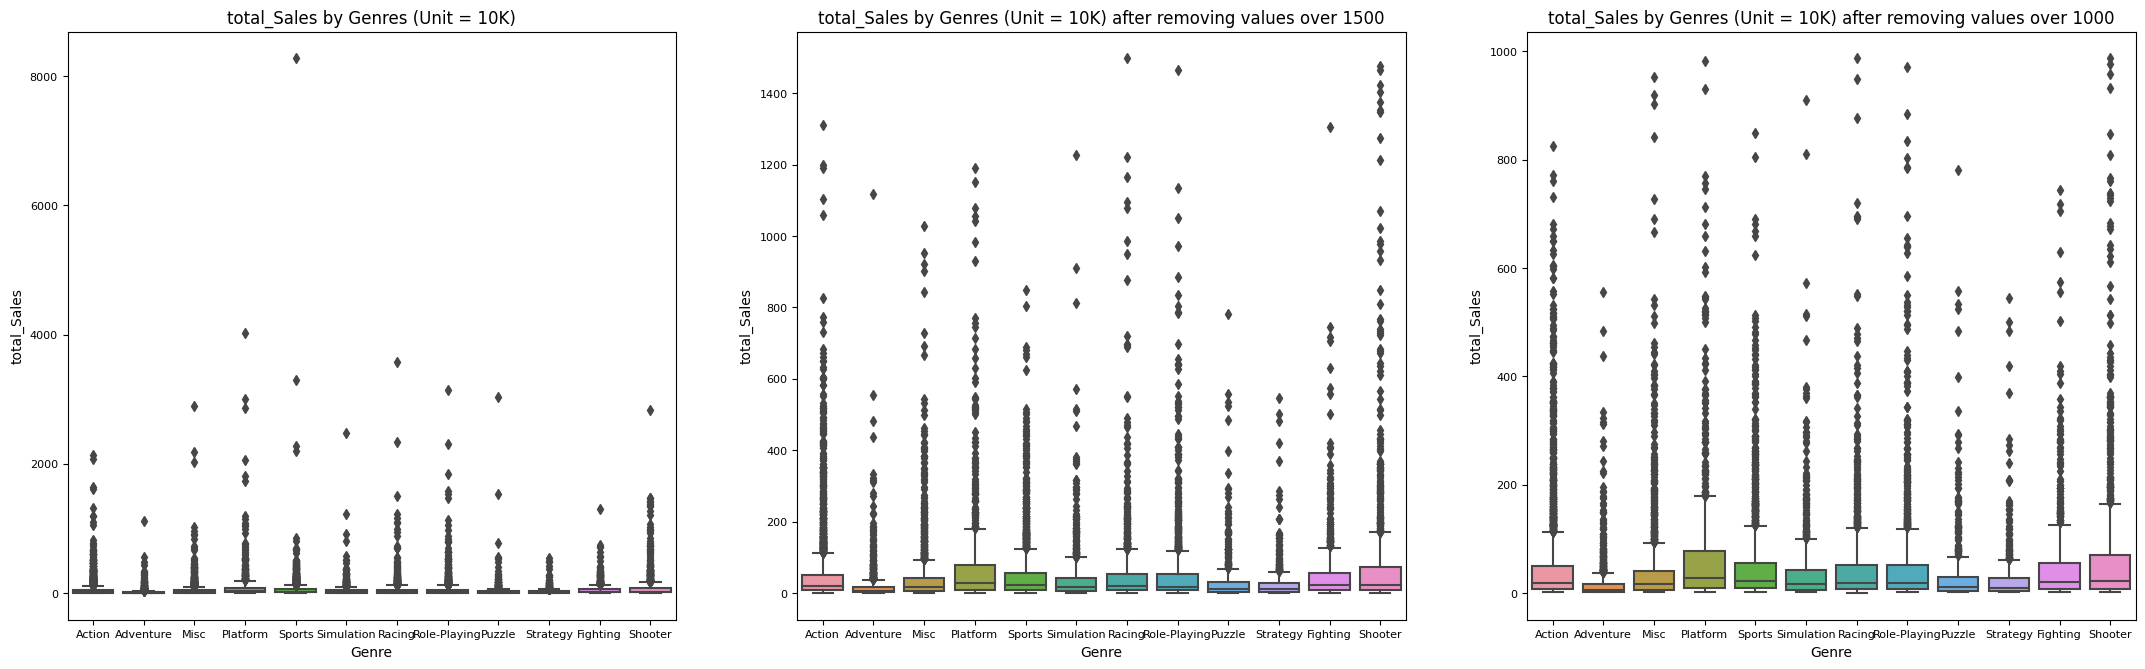

In [ ]:
# Comparing boxplots after removing the outliers depending on the two conditions
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, 
                    top=0.99, wspace=None, hspace=0.2)
ax = axs.flatten()

sns.boxplot(x='Genre', y='total_Sales', data=df, ax=ax[0])
ax[0].set_title("total_Sales by Genres (Unit = 10K)", fontsize=12)
ax[0].tick_params(labelsize=8)

sns.boxplot(x='Genre', y='total_Sales', data=df_removed_1500, ax=ax[1])
ax[1].set_title("total_Sales by Genres (Unit = 10K) after removing values over 1500", fontsize=12)
ax[1].tick_params(labelsize=8)

sns.boxplot(x='Genre', y='total_Sales', data=df_removed_1000, ax=ax[2])
ax[2].set_title("total_Sales by Genres (Unit = 10K) after removing values over 1000", fontsize=12)
ax[2].tick_params(labelsize=8)

plt.show()

total_Sales값 1000 이상의 값을 이상치로 설정 시, ***특정 게임장르(Action, Platform, Racing, Role-Playing, Shooter)**가 받는 패널티가 커진다. <br>
따라서, 높은 Sales를 보이는 게임장르들의 트렌드를 최대한 유지하기 위해 total_Sales값 1500 이상을 이상치로 정의한다.

In [ ]:
df = df_removed_1500

# 2.Analysis

### 2.1. Popular game genres differ depending on regions

#### 2.1.1 Making a pivot table composed of Sales and Genre

In [ ]:
df.Genre.unique()

array(['Action', 'Adventure', 'Misc', 'Platform', 'Sports', 'Simulation',
       'Racing', 'Role-Playing', 'Puzzle', 'Strategy', 'Fighting',
       'Shooter'], dtype=object)

In [ ]:
# 장르/지역별 Sales 합계 데이터프레이밍
Action_NA_Sales = df[df['Genre'] == 'Action']['NA_Sales'].sum()
Action_EU_Sales = df[df['Genre'] == 'Action']['EU_Sales'].sum()
Action_JP_Sales = df[df['Genre'] == 'Action']['JP_Sales'].sum()
Action_Other_Sales = df[df['Genre'] == 'Action']['Other_Sales'].sum()

Adventure_NA_Sales = df[df['Genre'] == 'Adventure']['NA_Sales'].sum()
Adventure_EU_Sales = df[df['Genre'] == 'Adventure']['EU_Sales'].sum()
Adventure_JP_Sales = df[df['Genre'] == 'Adventure']['JP_Sales'].sum()
Adventure_Other_Sales = df[df['Genre'] == 'Adventure']['Other_Sales'].sum()

Misc_NA_Sales = df[df['Genre'] == 'Misc']['NA_Sales'].sum()
Misc_EU_Sales = df[df['Genre'] == 'Misc']['EU_Sales'].sum()
Misc_JP_Sales = df[df['Genre'] == 'Misc']['JP_Sales'].sum()
Misc_Other_Sales = df[df['Genre'] == 'Misc']['Other_Sales'].sum()

Platform_NA_Sales = df[df['Genre'] == 'Platform']['NA_Sales'].sum()
Platform_EU_Sales = df[df['Genre'] == 'Platform']['EU_Sales'].sum()
Platform_JP_Sales = df[df['Genre'] == 'Platform']['JP_Sales'].sum()
Platform_Other_Sales = df[df['Genre'] == 'Platform']['Other_Sales'].sum()

Sports_NA_Sales = df[df['Genre'] == 'Sports']['NA_Sales'].sum()
Sports_EU_Sales = df[df['Genre'] == 'Sports']['EU_Sales'].sum()
Sports_JP_Sales = df[df['Genre'] == 'Sports']['JP_Sales'].sum()
Sports_Other_Sales = df[df['Genre'] == 'Sports']['Other_Sales'].sum()

Simulation_NA_Sales = df[df['Genre'] == 'Simulation']['NA_Sales'].sum()
Simulation_EU_Sales = df[df['Genre'] == 'Simulation']['EU_Sales'].sum()
Simulation_JP_Sales = df[df['Genre'] == 'Simulation']['JP_Sales'].sum()
Simulation_Other_Sales = df[df['Genre'] == 'Simulation']['Other_Sales'].sum()

Racing_NA_Sales = df[df['Genre'] == 'Racing']['NA_Sales'].sum()
Racing_EU_Sales = df[df['Genre'] == 'Racing']['EU_Sales'].sum()
Racing_JP_Sales = df[df['Genre'] == 'Racing']['JP_Sales'].sum()
Racing_Other_Sales = df[df['Genre'] == 'Racing']['Other_Sales'].sum()

RolePlaying_NA_Sales = df[df['Genre'] == 'Role-Playing']['NA_Sales'].sum()
RolePlaying_EU_Sales = df[df['Genre'] == 'Role-Playing']['EU_Sales'].sum()
RolePlaying_JP_Sales = df[df['Genre'] == 'Role-Playing']['JP_Sales'].sum()
RolePlaying_Other_Sales = df[df['Genre'] == 'Role-Playing']['Other_Sales'].sum()

Puzzle_NA_Sales = df[df['Genre'] == 'Puzzle']['NA_Sales'].sum()
Puzzle_EU_Sales = df[df['Genre'] == 'Puzzle']['EU_Sales'].sum()
Puzzle_JP_Sales = df[df['Genre'] == 'Puzzle']['JP_Sales'].sum()
Puzzle_Other_Sales = df[df['Genre'] == 'Puzzle']['Other_Sales'].sum()

Strategy_NA_Sales = df[df['Genre'] == 'Strategy']['NA_Sales'].sum()
Strategy_EU_Sales = df[df['Genre'] == 'Strategy']['EU_Sales'].sum()
Strategy_JP_Sales = df[df['Genre'] == 'Strategy']['JP_Sales'].sum()
Strategy_Other_Sales = df[df['Genre'] == 'Strategy']['Other_Sales'].sum()

Fighting_NA_Sales = df[df['Genre'] == 'Fighting']['NA_Sales'].sum()
Fighting_EU_Sales = df[df['Genre'] == 'Fighting']['EU_Sales'].sum()
Fighting_JP_Sales = df[df['Genre'] == 'Fighting']['JP_Sales'].sum()
Fighting_Other_Sales = df[df['Genre'] == 'Fighting']['Other_Sales'].sum()

Shooter_NA_Sales = df[df['Genre'] == 'Shooter']['NA_Sales'].sum()
Shooter_EU_Sales = df[df['Genre'] == 'Shooter']['EU_Sales'].sum()
Shooter_JP_Sales = df[df['Genre'] == 'Shooter']['JP_Sales'].sum()
Shooter_Other_Sales = df[df['Genre'] == 'Shooter']['Other_Sales'].sum()

In [ ]:
sum_by_genre_region = [["Action",Action_NA_Sales,Action_EU_Sales,Action_JP_Sales,Action_Other_Sales],
                       ["Adventure",Adventure_NA_Sales,Adventure_EU_Sales,Adventure_JP_Sales,Adventure_Other_Sales],
                       ["Misc",Misc_NA_Sales,Misc_EU_Sales,Misc_JP_Sales,Misc_Other_Sales],
                       ["Platform",Platform_NA_Sales,Platform_EU_Sales,Platform_JP_Sales,Platform_Other_Sales],
                       ["Sports",Sports_NA_Sales,Sports_EU_Sales,Sports_JP_Sales,Sports_Other_Sales],
                       ["Simulation",Simulation_NA_Sales,Simulation_EU_Sales,Simulation_JP_Sales,Simulation_Other_Sales],
                       ["Racing",Racing_NA_Sales,Racing_EU_Sales,Racing_JP_Sales,Racing_Other_Sales],
                       ["RolePlaying",RolePlaying_NA_Sales,RolePlaying_EU_Sales,RolePlaying_JP_Sales,RolePlaying_Other_Sales],
                       ["Puzzle",Puzzle_NA_Sales,Puzzle_EU_Sales,Puzzle_JP_Sales,Puzzle_Other_Sales],
                       ["Strategy",Strategy_NA_Sales,Strategy_EU_Sales,Strategy_JP_Sales,Strategy_Other_Sales],
                       ["Fighting",Fighting_NA_Sales,Fighting_EU_Sales,Fighting_JP_Sales,Fighting_Other_Sales],
                       ["Shooter",Shooter_NA_Sales,Shooter_EU_Sales,Shooter_JP_Sales,Shooter_Other_Sales]]

genre_region = pd.DataFrame(sum_by_genre_region, columns=["Genre","NA_Sales","EU_Sales","JP_Sales","Other_Sales"])
genre_region['Genre'].astype('category')
genre_region

Genre  NA_Sales  EU_Sales  JP_Sales  Other_Sales
0        Action   82427.0   49317.0   15469.0      16612.0
1     Adventure   10179.0    6366.0    5187.0       1670.0
2          Misc   36098.0   18475.0    9685.0       6607.0
3      Platform   35718.0   17086.0   10096.0       4409.0
4        Sports   59199.0   31432.0   12158.0      11699.0
5    Simulation   17236.0   10199.0    6161.0       2857.0
6        Racing   32904.0   21457.0    4840.0       7128.0
7   RolePlaying   28044.0   15632.0   30844.0       5233.0
8        Puzzle    9494.0    4285.0    4670.0       1068.0
9      Strategy    6783.0    4482.0    4910.0       1123.0
10     Fighting   22035.0    9990.0    8714.0       3615.0
11      Shooter   54755.0   30960.0    3790.0      10139.0

In [ ]:
# tidy 형태로 변환
tidy = genre_region.melt(id_vars = 'Genre', value_vars=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
tidy.columns = ['Genre','Regions','Sales']
tidy

Genre      Regions    Sales
0        Action     NA_Sales  82427.0
1     Adventure     NA_Sales  10179.0
2          Misc     NA_Sales  36098.0
3      Platform     NA_Sales  35718.0
4        Sports     NA_Sales  59199.0
5    Simulation     NA_Sales  17236.0
6        Racing     NA_Sales  32904.0
7   RolePlaying     NA_Sales  28044.0
8        Puzzle     NA_Sales   9494.0
9      Strategy     NA_Sales   6783.0
10     Fighting     NA_Sales  22035.0
11      Shooter     NA_Sales  54755.0
12       Action     EU_Sales  49317.0
13    Adventure     EU_Sales   6366.0
14         Misc     EU_Sales  18475.0
15     Platform     EU_Sales  17086.0
16       Sports     EU_Sales  31432.0
17   Simulation     EU_Sales  10199.0
18       Racing     EU_Sales  21457.0
19  RolePlaying     EU_Sales  15632.0
20       Puzzle     EU_Sales   4285.0
21     Strategy     EU_Sales   4482.0
22     Fighting     EU_Sales   9990.0
23      Shooter     EU_Sales  30960.0
24       Action     JP_Sales  15469.0
25    Adventure     JP_Sales   5187.0
26         Misc     JP_Sales   9685.0
27     Platform     JP_Sales  10096.0
28       Sports     JP_Sales  12158.0
29   Simulation     JP_Sales   6161.0
30       Racing     JP_Sales   4840.0
31  RolePlaying     JP_Sales  30844.0
32       Puzzle     JP_Sales   4670.0
33     Strategy     JP_Sales   4910.0
34     Fighting     JP_Sales   8714.0
35      Shooter     JP_Sales   3790.0
36       Action  Other_Sales  16612.0
37    Adventure  Other_Sales   1670.0
38         Misc  Other_Sales   6607.0
39     Platform  Other_Sales   4409.0
40       Sports  Other_Sales  11699.0
41   Simulation  Other_Sales   2857.0
42       Racing  Other_Sales   7128.0
43  RolePlaying  Other_Sales   5233.0
44       Puzzle  Other_Sales   1068.0
45     Strategy  Other_Sales   1123.0
46     Fighting  Other_Sales   3615.0
47      Shooter  Other_Sales  10139.0

In [ ]:
# Crosstabulation
crosstab = tidy.pivot_table(index = 'Genre', columns = 'Regions', values = 'Sales')
crosstab

Regions      EU_Sales  JP_Sales  NA_Sales  Other_Sales
Genre                                                 
Action        49317.0   15469.0   82427.0      16612.0
Adventure      6366.0    5187.0   10179.0       1670.0
Fighting       9990.0    8714.0   22035.0       3615.0
Misc          18475.0    9685.0   36098.0       6607.0
Platform      17086.0   10096.0   35718.0       4409.0
Puzzle         4285.0    4670.0    9494.0       1068.0
Racing        21457.0    4840.0   32904.0       7128.0
RolePlaying   15632.0   30844.0   28044.0       5233.0
Shooter       30960.0    3790.0   54755.0      10139.0
Simulation    10199.0    6161.0   17236.0       2857.0
Sports        31432.0   12158.0   59199.0      11699.0
Strategy       4482.0    4910.0    6783.0       1123.0

#### 2.1.2. Chisquare two-sample test
> - Null hypothesis : Region and Game genre are independent
> - Alternative hypothesis : Region and Game genre are not independent
<br> 
<br>pvalue = 0, which means Region and Game genre are not independent

In [ ]:
# Chi-square test : two-sample test
chi2, p, dof, ex = chi2_contingency(crosstab, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}\nExpected Values: \n{}'
print(msg.format(chi2, p, dof, ex))

Test Statistic: 63140.44180151916
p-value: 0.0
Degree of Freedom: 33
Expected Values: 
[[44805.25651209 23765.76813568 80536.5108928  14717.46445943]
 [ 6400.32115303  3394.88176964 11504.44332619  2102.35375113]
 [12130.58048123  6434.34689388 21804.46454533  3984.60807956]
 [19381.19641525 10280.24513313 34837.29494533  6366.26350629]
 [18408.64953806  9764.38325924 33089.1622871   6046.80491561]
 [ 5337.79454507  2831.29251765  9594.57398501  1753.33895226]
 [18140.62480812  9622.21660108 32607.39344428  5958.76514653]
 [21812.01661901 11569.60968182 39206.64338919  7164.73030998]
 [27252.09815285 14455.15763841 48985.07609585  8951.6681129 ]
 [ 9969.69946977  5288.16447947 17920.32615031  3274.80990044]
 [31311.85232752 16608.54730547 56282.39926199 10285.20110503]
 [ 4730.909978    2509.38658453  8503.71167663  1553.99176084]]


#### 2.1.3. Visualizing to see a trend in {Genre x Region} with a colormap

- 북미와 유럽 지역의 경우, Action 게임이 가장 인기있고, Sports, Shooter 순으로 출고량이 높음
- 일본의 경우에도 장르별 비슷한 트렌드를 보이지만, 다른 지역과 달리 'Role-Playing' 장르의 출고량이 가장 높고, Shooter 장르는 가장 낮은 출고량을 보임

In [ ]:
cmap = sns.light_palette("#2ecc71", as_cmap=True)

(genre_region.style
    .background_gradient(cmap=cmap)
    .set_caption('colormap(Unit : 10K)')
    .format({'NA_Sales': "{:,}", 'EU_Sales': "{:,}", 'JP_Sales': "{:,}", 'Other_Sales': "{:,}"}))

사용X

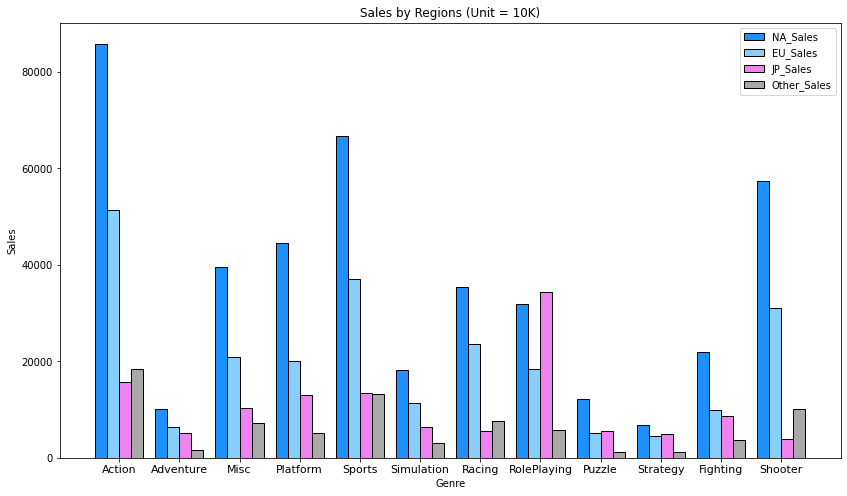

In [ ]:
"""
# Genre X Sales by Regions 시각화

Genre = df_sum_by_Genre_Region['Genre']
NA_Sales = df_sum_by_Genre_Region['NA_Sales']
EU_Sales = df_sum_by_Genre_Region['EU_Sales']
JP_Sales = df_sum_by_Genre_Region['JP_Sales']
Other_Sales = df_sum_by_Genre_Region['Other_Sales']

n = 12
r = np.arange(n)
width = 0.20

plt.figure(figsize=(14, 8))
plt.bar(r, NA_Sales, color = 'dodgerblue', width = width, edgecolor = 'black', label='NA_Sales')
plt.bar(r + width, EU_Sales, color = 'lightskyblue', width = width, edgecolor = 'black', label='EU_Sales')
plt.bar(r + width + width, JP_Sales, color = 'violet', width = width, edgecolor = 'black', label='JP_Sales')
plt.bar(r + width + width + width, Other_Sales, color = 'darkgray', width = width, edgecolor = 'black', label= 'Other_Sales')

plt.xlabel("Genre")
plt.ylabel("Sales")
plt.title("Sales by Regions (Unit = 10K)")
plt.xticks(r + width + width - 0.1 ,Genre, fontsize = 11)
plt.legend()

plt.show()
"""

### 2.2. Finding some trends by years

#### 2.2.2. Year X Sales

In [ ]:
# 연도별 Sales
year_sales = df.groupby(['Year']).sum()
year_sales = year_sales.drop(columns='total_Sales')
year_sales

NA_Sales  EU_Sales  JP_Sales  Other_Sales
Year                                                
1980-1984    8456.0     652.0    2209.0        111.0
1985-1989    5106.0    1203.0    6107.0        331.0
1990-1994   10258.0    3907.0   11435.0        633.0
1995-1999   43907.0   22402.0   23604.0       3864.0
2000-2004   86779.0   45536.0   19245.0      12155.0
2005-2009  133753.0   65314.0   25470.0      29113.0
2010-2014   94138.0   68298.0   23739.0      22211.0
2015-2020   12475.0   12369.0    4715.0       3742.0

In [ ]:
# Chi-square test : two-sample test
chi2, p, dof, ex = chi2_contingency(year_sales, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))

Test Statistic: 60590.12206735954
p-value: 0.0
Degree of Freedom: 21


In [ ]:
cmap = sns.light_palette("#2ecc71", as_cmap=True)

(year_sales.reset_index().style
    .background_gradient(cmap=cmap)
    .set_caption('colormap(Unit : 10K)')
    .format({'NA_Sales': "{:,}", 'EU_Sales': "{:,}", 'JP_Sales': "{:,}", 'Other_Sales': "{:,}"}))

#### 2.2.3. Year X Genres

In [ ]:
# by year and by genre and by Sales by region
year_genre_NA = df.groupby(by=['Year','Genre'])['NA_Sales'].sum().unstack()
year_genre_EU = df.groupby(by=['Year','Genre'])['EU_Sales'].sum().unstack()
year_genre_JP = df.groupby(by=['Year','Genre'])['JP_Sales'].sum().unstack()
year_genre_Other = df.groupby(by=['Year','Genre'])['Other_Sales'].sum().unstack()
year_genre_total = df.groupby(by=['Year','Genre'])['total_Sales'].sum().unstack()

# 결측값 0으로 대체
year_genre_NA = year_genre_NA.fillna(0)
year_genre_EU = year_genre_EU.fillna(0)
year_genre_JP = year_genre_JP.fillna(0)
year_genre_Other = year_genre_Other.fillna(0)
year_genre_total = year_genre_total.fillna(0)

# Suming up all genres' total sales by year range
# year_genre['total'] = year_genre[list(year_genre.columns)].sum(axis=1)

pvalue = 0 이므로 연도와 게임 장르는 서로 연관이 있음
<br> 즉, 연도별 선호되는 게임장르는 차이가 있다.

In [ ]:
# Chi-square test : two-sample test
chi2_NA, p_NA, dof_NA, ex_NA = chi2_contingency(year_genre_NA, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print('---'*5, 'NA', '---'*5)
print(msg.format(chi2_NA, p_NA, dof_NA))
print('\n')

chi2_EU, p_EU, dof_EU, ex_EU = chi2_contingency(year_genre_EU, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print('---'*5, 'EU', '---'*5)
print(msg.format(chi2_EU, p_EU, dof_EU))
print('\n')

chi2_JP, p_JP, dof_JP, ex_JP = chi2_contingency(year_genre_JP, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print('---'*5, 'JP', '---'*5)
print(msg.format(chi2_JP, p_JP, dof_JP))
print('\n')

chi2_Other, p_Other, dof_Other, ex_Other = chi2_contingency(year_genre_Other, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print('---'*5, 'Other', '---'*5)
print(msg.format(chi2_Other, p_Other, dof_Other))
print('\n')

chi2_total, p_total, dof_total, ex_total = chi2_contingency(year_genre_total, correction = False)
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print('---'*5, 'total', '---'*5)
print(msg.format(chi2_total, p_total, dof_total))
print('\n')

--------------- NA ---------------
Test Statistic: 68299.80574812813
p-value: 0.0
Degree of Freedom: 77


--------------- EU ---------------
Test Statistic: 31359.061434235715
p-value: 0.0
Degree of Freedom: 77


--------------- JP ---------------
Test Statistic: 25981.40330788421
p-value: 0.0
Degree of Freedom: 77


--------------- Other ---------------
Test Statistic: 10093.275049795742
p-value: 0.0
Degree of Freedom: 77


--------------- total ---------------
Test Statistic: 119382.1635425479
p-value: 0.0
Degree of Freedom: 77




In [ ]:
# 장르별로 비교하기 때문에 color bar는 점유율로 보겠다.
year_genre_NA = year_genre_NA.loc[:,:].style.bar(color='#702be0', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

year_genre_EU = year_genre_EU.loc[:,:].style.bar(color='#c65fd6', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

year_genre_JP = year_genre_JP.loc[:,:].style.bar(color='#d65fb8', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

year_genre_Other = year_genre_Other.loc[:,:].style.bar(color='#d65f8b', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

year_genre_total = year_genre_total.loc[:,:].style.bar(color='#d65f69', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

In [ ]:
year_genre_NA

In [ ]:
year_genre_EU

In [ ]:
year_genre_JP

In [ ]:
year_genre_Other

In [ ]:
year_genre_total

#### 2.2.4. Year X Platform

In [ ]:
# by year and by genre and by Sales by region
# df_10year = df.copy()
# df_10year['Year'] = df_10year['Year'].replace(["1980-1984", "1985-1989"],"1980-1989")
# df_10year['Year'] = df_10year['Year'].replace(["1990-1994", "1995-1999"],"1990-1999")
# df_10year['Year'] = df_10year['Year'].replace(["2000-2004", "2005-2009"],"2000-2009")
# df_10year['Year'] = df_10year['Year'].replace(["2010-2014", "2015-2020"],"2010-2020")

# year_platform_NA = df_10year.groupby(by=['Year','Platform'])['NA_Sales'].sum().unstack()
# year_platform_EU = df_10year.groupby(by=['Year','Platform'])['EU_Sales'].sum().unstack()
# year_platform_JP = df_10year.groupby(by=['Year','Platform'])['JP_Sales'].sum().unstack()
# year_platform_Other = df_10year.groupby(by=['Year','Platform'])['Other_Sales'].sum().unstack()
# year_platform_total = df_10year.groupby(by=['Year','Platform'])['total_Sales'].sum().unstack()

year_platform_NA = df.groupby(by=['Year','Platform'])['NA_Sales'].sum().unstack()
year_platform_EU = df.groupby(by=['Year','Platform'])['EU_Sales'].sum().unstack()
year_platform_JP = df.groupby(by=['Year','Platform'])['JP_Sales'].sum().unstack()
year_platform_Other = df.groupby(by=['Year','Platform'])['Other_Sales'].sum().unstack()
year_platform_total = df.groupby(by=['Year','Platform'])['total_Sales'].sum().unstack()

# 결측값 0으로 대체
year_platform_NA = year_platform_NA.fillna(0)
year_platform_EU = year_platform_EU.fillna(0)
year_platform_JP = year_platform_JP.fillna(0)
year_platform_Other = year_platform_Other.fillna(0)
year_platform_total = year_platform_total.fillna(0)

# Suming up all genres' total sales by year range
# year_genre['total'] = year_genre[list(year_genre.columns)].sum(axis=1)

In [ ]:
# 장르별로 비교하기 때문에 color bar는 점유율로 보겠다.
year_platform_NA = year_platform_NA.loc[:,:].style.bar(color='#702be0', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

year_platform_EU = year_platform_EU.loc[:,:].style.bar(color='#c65fd6', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

year_platform_JP = year_platform_JP.loc[:,:].style.bar(color='#d65fb8', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

year_platform_Other = year_platform_Other.loc[:,:].style.bar(color='#d65f8b', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

year_platform_total = year_platform_total.loc[:,:].style.bar(color='#d65f69', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

In [ ]:
year_platform_NA

In [ ]:
year_platform_EU

In [ ]:
year_platform_JP

In [ ]:
year_platform_Other

In [ ]:
year_platform_total

### 2.3. Analysis by year

In [ ]:
# (NA + EU + Other) genre
year_genre_NA_for_sum = df.groupby(by=['Year','Genre'])['NA_Sales'].sum()
year_genre_EU_for_sum = df.groupby(by=['Year','Genre'])['EU_Sales'].sum()
year_genre_Other_for_sum = df.groupby(by=['Year','Genre'])['Other_Sales'].sum()
year_genre_no_JP = (year_genre_NA_for_sum + year_genre_EU_for_sum + year_genre_Other_for_sum).unstack()
# Replacing missing values with 0
year_genre_no_JP = year_genre_no_JP.fillna(0)

# (NA + EU + Other) platform
year_platform_NA_for_sum = df.groupby(by=['Year','Platform'])['NA_Sales'].sum()
year_platform_EU_for_sum = df.groupby(by=['Year','Platform'])['EU_Sales'].sum()
year_platform_Other_for_sum = df.groupby(by=['Year','Platform'])['Other_Sales'].sum()
year_platform_no_JP = (year_platform_NA_for_sum + year_platform_EU_for_sum + year_platform_Other_for_sum).unstack()
# Replacing missing values with 0
year_platform_no_JP = year_platform_no_JP.fillna(0)

# color map
year_genre_no_JP = year_genre_no_JP.loc[:,:].style.bar(color='#702be0', axis = 1)\
.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}", 'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}"})

year_platform_no_JP = year_platform_no_JP.loc[:,:].style.bar(color='#702be0', axis = 1)\
.format({'2600': "{:,}", '3DO': "{:,}", '3DS': "{:,}", 'DC': "{:,}", 'DS': "{:,}", 'GB': "{:,}", 'GBA': "{:,}", 'GC': "{:,}", 'GEN': "{:,}", 'GG': "{:,}",'N64': "{:,}",'NES': "{:,}",
         'NG': "{:,}",'PC': "{:,}",'PCFX': "{:,}",'PS': "{:,}",'PS2': "{:,}",'PS3': "{:,}",'PS4': "{:,}",'PSP': "{:,}",'PSV': "{:,}",'SAT': "{:,}",'SCD': "{:,}",'SNES': "{:,}",
         'TG16': "{:,}",'WS': "{:,}",'Wii': "{:,}",'WiiU': "{:,}",'X360': "{:,}",'XB': "{:,}",'XOne': "{:,}"})

In [ ]:
df

Name  ... total_Sales
1                        Candace Kane's Candy Factory  ...         4.0
2                                      The Munchables  ...        18.0
3      Otome wa Oanesama Boku ni Koi Shiteru Portable  ...         2.0
4                    Deal or No Deal: Special Edition  ...         4.0
5           Ben 10 Ultimate Alien: Cosmic Destruction  ...        25.0
...                                               ...  ...         ...
16594                         Ice Age 2: The Meltdown  ...        20.0
16595                     Rainbow Islands: Revolution  ...         1.0
16596                                        NBA 2K16  ...        79.0
16597                     Toukiden: The Age of Demons  ...        38.0
16598                        The King of Fighters '95  ...        17.0

[16213 rows x 10 columns]

In [ ]:
# Condifions of year
y19801984 = df['Year'] == '1980-1984'
y19851989 = df['Year'] == '1985-1989'
y19901994 = df['Year'] == '1990-1994'
y19951999 = df['Year'] == '1995-1999'
y20002004 = df['Year'] == '2000-2004'
y20052009 = df['Year'] == '2005-2009'
y20102014 = df['Year'] == '2010-2014'
y20152020 = df['Year'] == '2015-2020'

# Condifions of genre
Action = df['Genre'] == 'Action'
Adventure = df['Genre'] == 'Adventure'
Fighting = df['Genre'] == 'Fighting'
Misc = df['Genre'] == 'Misc'
Platform = df['Genre'] == 'Platform'
Puzzle = df['Genre'] == 'Puzzle'
Racing = df['Genre'] == 'Racing'
RolePlaying = df['Genre'] == 'Role-Playing'
Shooter = df['Genre'] == 'Shooter'
Simulation = df['Genre'] == 'Simulation'
Sports = df['Genre'] == 'Sports'
Strategy = df['Genre'] == 'Strategy'

# Condifions of platform
PS = df['Platform'] == 'PS'
N64 = df['Platform'] == 'N64'
GB = df['Platform'] == 'GB'

In [ ]:
year_genre_no_JP

In [ ]:
year_genre_JP

In [ ]:
year_platform_no_JP

In [ ]:
year_platform_JP

#### 2.3.1. 1980-1984

<br>

1.   NA + EU + Other
- Action, Platform, Puzzle, Shooter 게임 장르가 강세
- 1980년 초 개발된 최초 콘솔게임기 Atari의 2600으로 NA, EU 지역의 콘솔 게임 시장규모 증가

<br>

2.   JP
- Misc, Racing, Sports 게임 장르가 강세인 일본에서는 2600 기기보다는 닌텐도의 NES(Nintendo Entertainment System:가정용 비디오게임기) 콘솔기기의 시장 점유율이 높음
- 해당 3개의 장르에서 출고량 1,2,3위의 경우 NES 콘솔기기의 게임이 차지



In [ ]:
Action_19801984 = df[Action & y19801984]
print(len(Action_19801984.Name)) # 게임(unique) 142개
Action_19801984.sort_values('total_Sales', ascending=False).head(10)

52


Name Platform  ... Other_Sales total_Sales
1383                       Frogger     2600  ...         2.0       220.0
5321   E.T.: The Extra Terrestrial     2600  ...         2.0       197.0
9656                       Pinball      NES  ...         3.0       185.0
14739                   Spider-Man     2600  ...         1.0        93.0
16473             Custer's Revenge     2600  ...         1.0        82.0
8725                         Alien     2600  ...         1.0        79.0
13129                     Air Raid     2600  ...         1.0        77.0
6105               Crystal Castles     2600  ...         1.0        77.0
1061                     King Kong     2600  ...         1.0        70.0
15873           Adventures of Tron     2600  ...         1.0        67.0

[10 rows x 10 columns]

In [ ]:
Platform_19801984 = df[Platform & y19801984] 
print(len(Platform_19801984.Name)) # 게임(unique) 142개
Platform_19801984.sort_values('total_Sales', ascending=False).head(10)

14


Name Platform  ... Other_Sales total_Sales
15886                  Pitfall!     2600  ...         5.0       450.0
10082               Mario Bros.      NES  ...         2.0       228.0
10126               Mario Bros.     2600  ...         2.0       159.0
13453               Donkey Kong     2600  ...         2.0       146.0
16364  Pitfall II: Lost Caverns     2600  ...         2.0       131.0
10571               Donkey Kong      NES  ...         1.0       113.0
10658           Donkey Kong Jr.      NES  ...         1.0       111.0
10826                    Popeye      NES  ...         2.0       110.0
13549               Jungle Hunt     2600  ...         1.0       110.0
3553                      Joust     2600  ...         1.0       108.0

[10 rows x 10 columns]

In [ ]:
Puzzle_19801984 = df[Puzzle & y19801984] 
print(len(Puzzle_19801984.Name)) # 게임(unique) 142개
Puzzle_19801984.sort_values('total_Sales', ascending=False).head(10)

9


Name Platform       Year  ... JP_Sales Other_Sales  total_Sales
5821        Pac-Man     2600  1980-1984  ...      0.0         8.0        781.0
5073    Ms. Pac-Man     2600  1980-1984  ...      0.0         2.0        166.0
3911        Dig Dug     2600  1980-1984  ...      0.0         2.0        164.0
4101        Pac-Man      NES  1980-1984  ...     85.0         2.0        122.0
2002    Lode Runner      NES  1980-1984  ...    110.0         0.0        110.0
8940   Clu Clu Land      NES  1980-1984  ...     28.0         2.0         82.0
12922   Jr. Pac-Man     2600  1980-1984  ...      0.0         1.0         78.0
5484     BurgerTime     2600  1980-1984  ...      0.0         1.0         59.0
15478        Q*bert     2600  1980-1984  ...      0.0         1.0         59.0

[9 rows x 10 columns]

In [ ]:
Shooter_19801984 = df[Shooter & y19801984] 
print(len(Shooter_19801984.Name)) # 게임(unique) 142개
Shooter_19801984.sort_values('total_Sales', ascending=False).head(10)

20


Name Platform       Year  ... JP_Sales Other_Sales  total_Sales
5724         Asteroids     2600  1980-1984  ...      0.0         5.0        431.0
15013  Missile Command     2600  1980-1984  ...      0.0         3.0        276.0
9110      Demon Attack     2600  1980-1984  ...      0.0         2.0        213.0
4357        River Raid     2600  1980-1984  ...      0.0         2.0        160.0
10616          Xevious      NES  1980-1984  ...    127.0         1.0        152.0
1707         Centipede     2600  1980-1984  ...      0.0         1.0        135.0
13101    Hogan's Alley      NES  1980-1984  ...     41.0         2.0        127.0
8324          Atlantis     2600  1980-1984  ...      0.0         1.0        127.0
1433       Moon Patrol     2600  1980-1984  ...      0.0         1.0        112.0
2367         Megamania     2600  1980-1984  ...      0.0         1.0        110.0

[10 rows x 10 columns]

In [ ]:
Misc_19801984 = df[Misc & y19801984]
print(len(Misc_19801984.Name)) # 게임(unique) 142개
Misc_19801984.sort_values('total_Sales', ascending=False).head(10)

7


Name Platform  ... Other_Sales total_Sales
10659             Mahjong      NES  ...         0.0       214.0
6387   4 Nin uchi Mahjong      NES  ...         0.0       145.0
5939              Kaboom!     2600  ...         1.0       115.0
10122            Defender     2600  ...         1.0       105.0
6522               Enduro     2600  ...         1.0        87.0
9227               Bridge     2600  ...         0.0        27.0
7318             Checkers     2600  ...         0.0        23.0

[7 rows x 10 columns]

In [ ]:
Racing_19801984 = df[Racing & y19801984]
print(len(Racing_19801984.Name)) # 게임(unique) 142개
Racing_19801984.sort_values('total_Sales', ascending=False).head(10)

6


Name Platform       Year  ... JP_Sales Other_Sales  total_Sales
6636      Excitebike      NES  1980-1984  ...    157.0         7.0        416.0
9643         F1 Race      NES  1980-1984  ...    152.0         0.0        152.0
15516  Pole Position     2600  1980-1984  ...      0.0         1.0        118.0
14985     Grand Prix     2600  1980-1984  ...      0.0         0.0         48.0
13362  Bump 'n' Jump     2600  1980-1984  ...      0.0         0.0         39.0
38         Beamrider     2600  1980-1984  ...      0.0         0.0         27.0

[6 rows x 10 columns]

In [ ]:
Sports_19801984 = df[Sports & y19801984]
print(len(Sports_19801984.Name)) # 게임(unique) 142개
Sports_19801984.sort_values('total_Sales', ascending=False).head(10)

9


Name Platform  ... Other_Sales total_Sales
5975                       Golf      NES  ...         4.0       400.0
467                    Baseball      NES  ...         2.0       320.0
10218                    Tennis      NES  ...         2.0       217.0
4703   The Activision Decathlon     2600  ...         1.0        56.0
12857         RealSports Tennis     2600  ...         1.0        50.0
8609        RealSports Football     2600  ...         0.0        25.0
6872        RealSports Baseball     2600  ...         0.0        21.0
1402       International Soccer     2600  ...         0.0        19.0
2619      RealSports Volleyball     2600  ...         0.0        13.0

[9 rows x 10 columns]

- 1980년대 초 최초의 가정용 콘솔게임기 ATARI 2600 등장으로 콘솔게임시장이 생겨났다.
- ATARI 쇼크 이후, 1980년대 중반 콘솔게임 방식을 적극적으로 계승한 NES(Nintendo Entertainment System:가정용 비디오게임기)가 등장하며 콘솔게임기 시장은 점진적으로 회복했다.
- 1990년대 초반 닌텐도의 GB(Game Boy), SEGA의 GEN

- 시간이 지남에 따라 다양한 게임 기기들이 생겨남으로써 Platform 장르는 다른 게임 장르들에게 점유율을 뺏기게 되었다.

#### 2.3.2. 1985-1989

<br>

1.   NA + EU + Other
- 1980-1984 트렌드와 비슷

<br>

2.   JP
- Nintendo사의 NES 플랫폼 The Legend of Zelda 게임 출시로 Action 장르 점유율 증가
- Nintendo사의 NES 플랫폼 Super Mario series로 Platform 장르 점유율 증가
- 다양한 퍼블리셔의 NES 플랫폼을 통해 출시된 다양한 Role-Playing 게임들이 일본 콘솔게임 시장에서 큰 인기
- 다른 게임장르의 강세로 Misc, Racing 게임장르 점유율은 감소



In [ ]:
Action_19851989 = df[Action & y19851989] 
print(len(Action_19851989.Name)) # 게임(unique) 142개
Action_19851989.sort_values('total_Sales', ascending=False).head(10)

14


Name Platform  ... Other_Sales total_Sales
10792             The Legend of Zelda      NES  ...        14.0       650.0
802      Teenage Mutant Ninja Turtles      NES  ...         4.0       417.0
14142                         Kung Fu      NES  ...         6.0       350.0
2895                          Metroid      NES  ...         5.0       273.0
10743               Ghosts 'n Goblins      NES  ...         3.0       164.0
16394                      Mega Man 2      NES  ...         1.0       151.0
3227                         Doraemon      NES  ...         0.0       115.0
16194                        Commando      NES  ...         3.0       115.0
6483                   Kung-Fu Master     2600  ...         1.0        65.0
1769   The Mysterious Murasame Castle      NES  ...         0.0        57.0

[10 rows x 10 columns]

In [ ]:
Platform_19851989 = df[Platform & y19851989] 
print(len(Platform_19851989.Name)) # 게임(unique) 142개
Platform_19851989.sort_values('total_Sales', ascending=False).head(10)

16


Name  ... total_Sales
7495                                 Super Mario Bros. 2  ...       746.0
8421                  Super Mario Bros.: The Lost Levels  ...       265.0
3419                                          Kid Icarus  ...       176.0
8389                                  Disney's DuckTales  ...       167.0
6803                                Donkey Kong Classics  ...       156.0
4881   Ninja Hattori Kun: Ninja wa Shuugyou Degogiru ...  ...       150.0
13711                                        Ice Climber  ...       150.0
11376                                 Disney's DuckTales  ...       143.0
6778                                         Castlevania  ...       123.0
7062                    Ganbare Goemon! Karakuri Douchuu  ...       120.0

[10 rows x 10 columns]

In [ ]:
RolePlaying_19851989 = df[RolePlaying & y19851989] 
print(len(RolePlaying_19851989.Name)) # 게임(unique) 142개
RolePlaying_19851989.sort_values('total_Sales', ascending=False).head(10)

9


Name  ... total_Sales
15144                             Dragon Warrior III  ...       387.0
4150                               Dragon Warrior II  ...       256.0
11611                                 Dragon Warrior  ...       252.0
157    Gegege no Kitarou 2: Youkai Gundan no Chousen  ...       125.0
12156                  Dragon Ball: Daimaou Fukkatsu  ...       125.0
1246                    Famicom Jump: Eiyuu Retsuden  ...       110.0
14509                       The Final Fantasy Legend  ...       110.0
15853                                  Final Fantasy  ...        84.0
7752                                Final Fantasy II  ...        76.0

[9 rows x 10 columns]

In [ ]:
RolePlaying_19801984 = df[RolePlaying & y19801984] 
print(len(RolePlaying_19801984.Name)) # 게임(unique) 142개
RolePlaying_19801984.sort_values('total_Sales', ascending=False).head(10)

0


Empty DataFrame
Columns: [Name, Platform, Year, Genre, Publisher, NA_Sales, EU_Sales, JP_Sales, Other_Sales, total_Sales]
Index: []

#### 2.3.2. 1995-1999
N64, PS 플랫폼 출시
<br> 게임수 크게 증가
<br>

1.   NA + EU + Other
- PS(Play-Station), N64 콘솔기기의 출시로 콘솔게임 시장규모가 크게 증가
- 특히, Action, Racing, Sports, Shooter 게임장르의 절대 출고량이 크게 증가했으며, 해당 장르들에서 높은 출고량을 보인 플랫폼은 PS > N64 
<br> (수정필요)
> Action
- N64 플랫폼에 출시된 The Legend of Zelda
- 1995-1999년대 Action 장르 출고량의 대부분은 PS 플랫폼에 출시된 게임들이 차지함
> Racing
- 1990년에 소개된 SNES(Super Nintendo Entertainment System)플랫폼의 Super Mario Kart가 빅히트를 침
- 이후, 1996년 닌텐도사는 N64(Home video game console)를 개발하여 Mario Kart 64를 포함한 다양한 Racing 장르 게임을 출시
- 또한, 1994년 소개된 플레이스테이션 플랫폼의 Gran Turismo가 Racing 장르를 선도하기 시작
> Sports
- 1990년대 중반에 소개된 PlayStation, Sports장르의 경우, PS 플랫폼 내 다양한 게임이 출시되었기 때문에 1980년대보다 더 높은 출고량을 보임 (어떤 특정 게임의 영향이 아니라고 봄)
<br>
<br>
2.   JP
- 일본도 마찬가지로 콘솔게임 시장규모 증가
- 특히 Role-Playing 게임장르의 출고량이 크게 증가했으며, 해당 장르에서 높은 출고량을 보인 플랫폼은 PS > SNES > SAT > GB
<br> (수정필요)
- Nintendo에서 게임보이에 Pokemon 시리즈를 출시하며 북미,유럽,일본 전체에서 높은 출고량을 보임
- Square사가 플레이스테이션 플랫폼에 출시한 Final Fantasy VII, VIII가 그 뒤를 이음

In [ ]:
# Changes in the number of games by year
dic = {
        'year' : ['1980-1984', '1985-1989', '1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014', '2015-2020'],
        'Action' : [len(df[Action & y19801984]['Name'].unique()), len(df[Action & y19851989]['Name'].unique()), len(df[Action & y19901994]['Name'].unique()), 
                    len(df[Action & y19951999]['Name'].unique()), len(df[Action & y20002004]['Name'].unique()), len(df[Action & y20052009]['Name'].unique()),
                    len(df[Action & y20102014]['Name'].unique()), len(df[Action & y20152020]['Name'].unique())],
        'Adventure' : [len(df[Adventure & y19801984]['Name'].unique()), len(df[Adventure & y19851989]['Name'].unique()), len(df[Adventure & y19901994]['Name'].unique()), 
                    len(df[Adventure & y19951999]['Name'].unique()), len(df[Adventure & y20002004]['Name'].unique()), len(df[Adventure & y20052009]['Name'].unique()),
                    len(df[Adventure & y20102014]['Name'].unique()), len(df[Adventure & y20152020]['Name'].unique())],
        'Fighting' : [len(df[Fighting & y19801984]['Name'].unique()), len(df[Fighting & y19851989]['Name'].unique()), len(df[Fighting & y19901994]['Name'].unique()), 
                      len(df[Fighting & y19951999]['Name'].unique()), len(df[Fighting & y20002004]['Name'].unique()), len(df[Fighting & y20052009]['Name'].unique()),
                      len(df[Fighting & y20102014]['Name'].unique()), len(df[Fighting & y20152020]['Name'].unique())],
        'Misc' : [len(df[Misc & y19801984]['Name'].unique()), len(df[Misc & y19851989]['Name'].unique()), len(df[Misc & y19901994]['Name'].unique()), 
                      len(df[Misc & y19951999]['Name'].unique()), len(df[Misc & y20002004]['Name'].unique()), len(df[Misc & y20052009]['Name'].unique()),
                      len(df[Misc & y20102014]['Name'].unique()), len(df[Misc & y20152020]['Name'].unique())],
        'Platform' : [len(df[Platform & y19801984]['Name'].unique()), len(df[Platform & y19851989]['Name'].unique()), len(df[Platform & y19901994]['Name'].unique()), 
                      len(df[Platform & y19951999]['Name'].unique()), len(df[Platform & y20002004]['Name'].unique()), len(df[Platform & y20052009]['Name'].unique()),
                      len(df[Platform & y20102014]['Name'].unique()), len(df[Platform & y20152020]['Name'].unique())],
        'Puzzle' : [len(df[Puzzle & y19801984]['Name'].unique()), len(df[Puzzle & y19851989]['Name'].unique()), len(df[Puzzle & y19901994]['Name'].unique()), 
                      len(df[Puzzle & y19951999]['Name'].unique()), len(df[Puzzle & y20002004]['Name'].unique()), len(df[Puzzle & y20052009]['Name'].unique()),
                      len(df[Puzzle & y20102014]['Name'].unique()), len(df[Puzzle & y20152020]['Name'].unique())],
        'Racing' : [len(df[Racing & y19801984]['Name'].unique()), len(df[Racing & y19851989]['Name'].unique()), len(df[Racing & y19901994]['Name'].unique()), 
                      len(df[Racing & y19951999]['Name'].unique()), len(df[Racing & y20002004]['Name'].unique()), len(df[Racing & y20052009]['Name'].unique()),
                      len(df[Racing & y20102014]['Name'].unique()), len(df[Racing & y20152020]['Name'].unique())],
        'RolePlaying' : [len(df[RolePlaying & y19801984]['Name'].unique()), len(df[RolePlaying & y19851989]['Name'].unique()), len(df[RolePlaying & y19901994]['Name'].unique()), 
                      len(df[RolePlaying & y19951999]['Name'].unique()), len(df[RolePlaying & y20002004]['Name'].unique()), len(df[RolePlaying & y20052009]['Name'].unique()),
                      len(df[RolePlaying & y20102014]['Name'].unique()), len(df[RolePlaying & y20152020]['Name'].unique())],
        'Shooter' : [len(df[Shooter & y19801984]['Name'].unique()), len(df[Shooter & y19851989]['Name'].unique()), len(df[Shooter & y19901994]['Name'].unique()), 
                      len(df[Shooter & y19951999]['Name'].unique()), len(df[Shooter & y20002004]['Name'].unique()), len(df[Shooter & y20052009]['Name'].unique()),
                      len(df[Shooter & y20102014]['Name'].unique()), len(df[Shooter & y20152020]['Name'].unique())],
        'Simulation' : [len(df[Simulation & y19801984]['Name'].unique()), len(df[Simulation & y19851989]['Name'].unique()), len(df[Simulation & y19901994]['Name'].unique()), 
                        len(df[Simulation & y19951999]['Name'].unique()), len(df[Simulation & y20002004]['Name'].unique()), len(df[Simulation & y20052009]['Name'].unique()),
                        len(df[Simulation & y20102014]['Name'].unique()), len(df[Simulation & y20152020]['Name'].unique())],
        'Sports' : [len(df[Sports & y19801984]['Name'].unique()), len(df[Sports & y19851989]['Name'].unique()), len(df[Sports & y19901994]['Name'].unique()), 
                        len(df[Sports & y19951999]['Name'].unique()), len(df[Sports & y20002004]['Name'].unique()), len(df[Sports & y20052009]['Name'].unique()),
                        len(df[Sports & y20102014]['Name'].unique()), len(df[Sports & y20152020]['Name'].unique())],
        'Strategy' : [len(df[Strategy & y19801984]['Name'].unique()), len(df[Strategy & y19851989]['Name'].unique()), len(df[Strategy & y19901994]['Name'].unique()), 
                        len(df[Strategy & y19951999]['Name'].unique()), len(df[Strategy & y20002004]['Name'].unique()), len(df[Strategy & y20052009]['Name'].unique()),
                        len(df[Strategy & y20102014]['Name'].unique()), len(df[Strategy & y20152020]['Name'].unique())],
        'total' : [len(df[y19801984]['Name'].unique()), len(df[y19851989]['Name'].unique()), len(df[y19901994]['Name'].unique()),
                   len(df[y19951999]['Name'].unique()), len(df[y20002004]['Name'].unique()), len(df[y20052009]['Name'].unique()),
                   len(df[y20102014]['Name'].unique()), len(df[y20152020]['Name'].unique())]
      }

games = pd.DataFrame(data=dic)

In [ ]:
games

year  Action  Adventure  Fighting  ...  Simulation  Sports  Strategy  total
0  1980-1984      52          1         1  ...           1       9         0    116
1  1985-1989      13          1         3  ...           2      13         0     77
2  1990-1994      19         10        36  ...          10      44        15    265
3  1995-1999     126         83       127  ...          72     241       100   1374
4  2000-2004     347        110       144  ...         108     378       112   2329
5  2005-2009     599        428       188  ...         359     448       217   4187
6  2010-2014     569        366        96  ...         152     229       117   2665
7  2015-2020     220         60        20  ...          22      33        24    567

[8 rows x 14 columns]

In [ ]:
# In the dataframe 'games', value 0 to 0.1 to avoid results with 'inf'
games.loc[(games['RolePlaying'] == 0), 'RolePlaying'] = 0.1
games.loc[(games['Strategy'] == 0), 'Strategy'] = 0.1

# A dataframe for changes in the number of games by year
games_change = pd.DataFrame(data=np.zeros(games.shape), columns=games.columns)
games_change['year'] = games['year']

# A for loop to calculate the changes
# iter = ['Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Racing', 'RolePlaying', 'Shooter', 'Simulation', 'Sports', 'Strategy', 'total']
iters = list(games.columns)
iters.remove('year')

for iter in iters:
    for i in range(len(games)):
        if i == 0:
            pass
        else:
            games_change.loc[i, iter] = round(((games.loc[i, iter] - games.loc[i-1, iter]) / games.loc[i-1, iter] * 100), 2)

In [ ]:
games_change = games_change.set_index('year')

In [ ]:
def style_negative(value, props=''):
    return props if value < 0 else None

games_change = games_change.style.applymap(style_negative, props='color:red;')\
                           .format({'Action': "{:.2f}%", 'Adventure': "{:.2f}%", 'Fighting': "{:.2f}%", 'Misc': "{:.2f}%",
                                    'Platform': "{:.2f}%", 'Puzzle': "{:.2f}%", 'Racing': "{:.2f}%", 'RolePlaying': "{:.2f}%",
                                    'Shooter': "{:.2f}%", 'Simulation': "{:.2f}%",'Sports': "{:.2f}%",'Strategy': "{:.2f}%",'total': "{:.2f}%"
                                    })

In [ ]:
games_change

In [ ]:
Action_19951999 = df[Action & y19951999] 
print(len(Action_19951999.Name)) # 게임(unique) 142개
Action_19951999.sort_values('total_Sales', ascending=False).head(10)

142


Name Platform  ... Other_Sales total_Sales
1965   The Legend of Zelda: Ocarina of Time      N64  ...        16.0       760.0
1763                                 Driver       PS  ...        33.0       626.0
2214                       Metal Gear Solid       PS  ...        24.0       603.0
6004                        Resident Evil 2       PS  ...        45.0       582.0
596                          Tomb Raider II       PS  ...        28.0       524.0
2299                          Resident Evil       PS  ...        73.0       505.0
563                             Tomb Raider       PS  ...        24.0       463.0
1046                                Frogger       PS  ...        11.0       417.0
6168           Resident Evil Director's Cut       PS  ...        25.0       378.0
10446              Resident Evil 3: Nemesis       PS  ...        11.0       372.0

[10 rows x 10 columns]

In [ ]:
Racing_19951999 = df[Racing & y19951999] 
print(len(Racing_19951999.Name)) # 게임(unique) 142개
Racing_19951999.sort_values('total_Sales', ascending=False).head(10)

166


Name Platform  ... Other_Sales total_Sales
4810                      Gran Turismo       PS  ...        52.0      1095.0
578                      Mario Kart 64      N64  ...        15.0       987.0
6504                    Gran Turismo 2       PS  ...        50.0       949.0
5631                 Diddy Kong Racing      N64  ...        10.0       489.0
13936                Crash Team Racing       PS  ...        21.0       479.0
16209  Need for Speed III: Hot Pursuit       PS  ...        13.0       313.0
6573         Star Wars Episode I Racer      N64  ...         4.0       311.0
3698                      Wave Race 64      N64  ...         4.0       294.0
7439                 Colin McRae Rally       PS  ...        22.0       286.0
5771                   Twisted Metal 2       PS  ...         7.0       244.0

[10 rows x 10 columns]

In [ ]:
Sports_19951999 = df[Sports & y19951999] 
print(len(Sports_19951999.Name)) # 게임(unique) 142개
Sports_19951999.sort_values('total_Sales', ascending=False).head(10)

259


Name Platform  ... Other_Sales total_Sales
9676          Tony Hawk's Pro Skater       PS  ...        20.0       502.0
10291                 Hot Shots Golf       PS  ...        18.0       280.0
4356                 Cool Boarders 3       PS  ...        10.0       231.0
15750                Cool Boarders 2       PS  ...         8.0       226.0
1272                  Derby Stallion       PS  ...        14.0       210.0
7196   1080°: TenEighty Snowboarding      N64  ...         5.0       204.0
16156               Hot Shots Golf 2       PS  ...         3.0       188.0
9272                       FIFA 2000       PS  ...        14.0       187.0
10036               NFL GameDay 2000       PS  ...        12.0       180.0
8360                 Madden NFL 2000       PS  ...         4.0       176.0

[10 rows x 10 columns]

In [ ]:
Shooter_19951999 = df[Shooter & y19951999] 
print(len(Shooter_19951999.Name)) # 게임(unique) 142개
Shooter_19951999.sort_values('total_Sales', ascending=False).head(10)

118


Name Platform  ... Other_Sales total_Sales
12001             GoldenEye 007      N64  ...        15.0       809.0
1123                  Half-Life       PC  ...         0.0       412.0
3968                Star Fox 64      N64  ...         4.0       404.0
14880  007: Tomorrow Never Dies       PS  ...        16.0       321.0
2121              Syphon Filter       PS  ...        11.0       288.0
5379             Medal of Honor       PS  ...        14.0       267.0
13336               Time Crisis       PS  ...        10.0       168.0
5508   Tom Clancy's Rainbow Six       PS  ...         8.0       164.0
3802           Die Hard Trilogy       PS  ...        10.0       153.0
12518  Duke Nukem: Time to Kill       PS  ...         7.0       138.0

[10 rows x 10 columns]

In [ ]:
RolePlaying_19951999 = df[RolePlaying & y19951999] 
print(len(RolePlaying_19951999.Name)) # 게임(unique) 142개
RolePlaying_19951999.sort_values('JP_Sales', ascending=False).head(10)

131


Name  ... total_Sales
6126                           Final Fantasy VIII  ...       786.0
11705                           Final Fantasy VII  ...       972.0
11346        Dragon Quest VI: Maboroshi no Daichi  ...       319.0
8534      Pokémon Yellow: Special Pikachu Edition  ...      1464.0
11664                     Dragon Warrior Monsters  ...       235.0
13421                              Chrono Trigger  ...       231.0
13298  Super Mario RPG: Legend of the Seven Stars  ...       214.0
4987      Dragon Quest III: Soshite Densetsu e...  ...       136.0
2630                        Final Fantasy Tactics  ...       245.0
2395                             Romancing SaGa 3  ...       130.0

[10 rows x 10 columns]

In [ ]:
# df = df.value_counts().rename_axis('unique_values').reset_index(name='counts')

print(Action_19951999['Platform'].value_counts(normalize=True))
print(Racing_19951999['Platform'].value_counts(normalize=True))
print(Sports_19951999['Platform'].value_counts(normalize=True))
print(Shooter_19951999['Platform'].value_counts(normalize=True))
print(RolePlaying_19951999['Platform'].value_counts(normalize=True))

PS      0.732394
N64     0.183099
PC      0.042254
SAT     0.021127
SNES    0.007042
DC      0.007042
GB      0.007042
Name: Platform, dtype: float64
PS      0.650602
N64     0.277108
SAT     0.030120
SNES    0.018072
DC      0.018072
PC      0.006024
Name: Platform, dtype: float64
PS      0.602317
N64     0.239382
SNES    0.073359
SAT     0.046332
DC      0.023166
GB      0.007722
PC      0.003861
NG      0.003861
Name: Platform, dtype: float64
PS      0.618644
N64     0.177966
SAT     0.161017
SNES    0.016949
TG16    0.008475
PC      0.008475
DC      0.008475
Name: Platform, dtype: float64
PS      0.587786
SNES    0.175573
SAT     0.129771
GB      0.045802
N64     0.022901
PC      0.015267
WS      0.015267
PCFX    0.007634
Name: Platform, dtype: float64


In [ ]:
year_genre_no_JP

In [ ]:
year_genre_JP

In [ ]:
year_platform_no_JP

In [ ]:
year_platform_JP

2000-2004 : PS2 / GBA(Game Boy Advance) / XB 출시
- Action, Racing, Sports 장르 : PS2, PS 플랫폼에서 절대출고량 가장 높고, 지난 5년(1995-1999) 대비 출고량 증가율 큼

In [ ]:
# pct change
group_Year_Genre['sum_Genre'] = group_Year_Genre[list(group_Year_Genre.columns)].sum(axis=1)

group_Year_Genre_pct = group_Year_Genre.copy()

In [ ]:
group_Year_Genre_pct['Ac_change'] = group_Year_Genre_pct['Action'].pct_change()
group_Year_Genre_pct['Ad_change'] = group_Year_Genre_pct['Adventure'].pct_change()
group_Year_Genre_pct['Ft_change'] = group_Year_Genre_pct['Fighting'].pct_change()
group_Year_Genre_pct['Mi_change'] = group_Year_Genre_pct['Misc'].pct_change()
group_Year_Genre_pct['Pf_change'] = group_Year_Genre_pct['Platform'].pct_change()
group_Year_Genre_pct['Pz_change'] = group_Year_Genre_pct['Puzzle'].pct_change()
group_Year_Genre_pct['Rc_change'] = group_Year_Genre_pct['Racing'].pct_change()
group_Year_Genre_pct['RP_change'] = group_Year_Genre_pct['Role-Playing'].pct_change()
group_Year_Genre_pct['St_change'] = group_Year_Genre_pct['Shooter'].pct_change()
group_Year_Genre_pct['Sm_change'] = group_Year_Genre_pct['Simulation'].pct_change()
group_Year_Genre_pct['Sp_change'] = group_Year_Genre_pct['Sports'].pct_change()
group_Year_Genre_pct['Sr_change'] = group_Year_Genre_pct['Strategy'].pct_change()
group_Year_Genre_pct['sum_change'] = group_Year_Genre_pct['sum_Genre'].pct_change()

In [ ]:
group_Year_Genre_pct = group_Year_Genre_pct[['Ac_change','Ad_change','Ft_change','Mi_change','Pf_change','Pz_change','Rc_change','RP_change','St_change','Sm_change',
                                             'Sp_change','Sr_change','sum_change']]

In [ ]:
def style_negative(value, props=''):
  return props if value < 0 else None

pct = group_Year_Genre_pct.style.applymap(style_negative, props='color:red;')\
.format({'Ac_change': "{:.2f}%", 'Ad_change': "{:.2f}%", 'Ft_change': "{:.2f}%", 'Mi_change': "{:.2f}%", 'Pf_change': "{:.2f}%", 'Pz_change': "{:.2f}%", 'Rc_change': "{:.2f}%", 'RP_change': "{:.2f}%",
         'St_change': "{:.2f}%", 'Sm_change': "{:.2f}%",'Sp_change': "{:.2f}%",'Sr_change': "{:.2f}%",'sum_change': "{:.2f}%"})

pct
#.format({'Action': "{:,}", 'Adventure': "{:,}", 'Fighting': "{:,}", 'Misc': "{:,}", 'Platform': "{:,}", 'Puzzle': "{:,}", 'Racing': "{:,}", 'Role-Playing': "{:,}", 'Shooter': "{:,}",
#         'Simulation': "{:,}",'Sports': "{:,}",'Strategy': "{:,}",'sum_Genre': "{:,}", 'Ac_change': "{:.2f}%", 'Ad_change': "{:.2f}", 'Ft_change': "{:.2f}", 'Mi_change': "{:.2f}", 'Pf_change': "{:.2f}", 'Pz_change': "{:.2f}", 'Rc_change': "{:.2f}", 'RP_change': "{:.2f}",
#         'St_change': "{:.2f}", 'Sm_change': "{:.2f}",'Sp_change': "{:.2f}",'Sr_change': "{:.2f}",'sum_change': "{:.2f}"})

In [ ]:
bar_Genre #다시 보기

In [ ]:
bar_Platform #다시 보기

In [ ]:
# 20002004 Action

grouped_cd_Action_20002004 = grouped[grouped_Action & grouped_20002004]
print(len(grouped_cd_Action_20002004.Name)) # 약 503개의 게임
grouped_cd_Action_20002004.sort_values('total_Sales', ascending=False).head()

503


Name Platform  ... Other_Sales total_Sales
14669        Grand Theft Auto: San Andreas      PS2  ...      1057.0      2081.0
5340           Grand Theft Auto: Vice City      PS2  ...       178.0      1615.0
9786                  Grand Theft Auto III      PS2  ...       130.0      1310.0
8299   Metal Gear Solid 2: Sons of Liberty      PS2  ...        72.0       605.0
8779                              Driver 2       PS  ...        25.0       473.0

[5 rows x 10 columns]

In [ ]:
# 20002004 Platform

grouped_cd_Platform_20002004 = grouped[grouped_Platform & grouped_20002004]
print(len(grouped_cd_Platform_20002004.Name)) # 약 297개의 게임
grouped_cd_Platform_20002004.sort_values('total_Sales', ascending=False).head(10)

297


Name Platform  ... Other_Sales total_Sales
12472                        Super Mario 64       DS  ...        98.0      1042.0
12863                  Super Mario Sunshine       GC  ...        17.0       631.0
1311                    Super Mario Advance      GBA  ...        20.0       549.0
14424                     Super Mario World      GBA  ...        20.0       547.0
10155  Crash Bandicoot: The Wrath of Cortex      PS2  ...        82.0       542.0
9829                    Super Mario Bros. 3      GBA  ...        20.0       521.0
8857              Spyro: Year of the Dragon       PS  ...        19.0       370.0
1506   Jak and Daxter: The Precursor Legacy      PS2  ...        33.0       365.0
10104                       Ratchet & Clank      PS2  ...        30.0       332.0
11034                          Sonic Heroes      PS2  ...        49.0       296.0

[10 rows x 10 columns]

In [ ]:
# 20002004 Racing

grouped_cd_Racing_20002004 = grouped[grouped_Racing & grouped_20002004]
print(len(grouped_cd_Racing_20002004.Name)) # 약 396개의 게임
grouped_cd_Racing_20002004.sort_values('total_Sales', ascending=False).head(10)

396


Name Platform  ... Other_Sales total_Sales
1005         Gran Turismo 3: A-Spec      PS2  ...       116.0      1497.0
14665                Gran Turismo 4      PS2  ...       753.0      1165.0
6528     Need for Speed Underground      PS2  ...       102.0       720.0
8002      Mario Kart: Double Dash!!       GC  ...        19.0       695.0
4923   Need for Speed Underground 2      PS2  ...       109.0       690.0
15508     Mario Kart: Super Circuit      GBA  ...        23.0       548.0
2214        The Simpsons: Hit & Run      PS2  ...        79.0       471.0
2782        The Simpsons: Road Rage      PS2  ...        42.0       361.0
165             Burnout 3: Takedown      PS2  ...        34.0       268.0
8332   Midnight Club: Street Racing      PS2  ...        14.0       263.0

[10 rows x 10 columns]

In [ ]:
# 20002004 Shooter

grouped_cd_Shooter_20002004 = grouped[grouped_Shooter & grouped_20002004]
print(len(grouped_cd_Shooter_20002004.Name)) # 295개의 게임
grouped_cd_Shooter_20002004.sort_values('total_Sales', ascending=False).head(20)

295


Name Platform  ... Other_Sales total_Sales
9495                                  Halo 2       XB  ...         8.0       848.0
6305               Medal of Honor: Frontline      PS2  ...        99.0       684.0
10300                   Halo: Combat Evolved       XB  ...         7.0       643.0
11521             Medal of Honor: Rising Sun      PS2  ...        80.0       514.0
5799                  SOCOM: U.S. Navy SEALs      PS2  ...        24.0       364.0
4227                  Star Wars: Battlefront      PS2  ...        44.0       362.0
12943       James Bond 007: Agent Under Fire      PS2  ...        41.0       354.0
4859               James Bond 007: Nightfire      PS2  ...        46.0       332.0
15291                              Max Payne      PS2  ...        22.0       331.0
11706              SOCOM II: U.S. Navy SEALs      PS2  ...        15.0       294.0
14448              Call of Duty: Finest Hour      PS2  ...        24.0       288.0
3659                           Metroid Prime       GC  ...         9.0       282.0
7016                             Half-Life 2       PC  ...         0.0       238.0
7765   James Bond 007: Everything or Nothing      PS2  ...        32.0       232.0
2041                         Syphon Filter 2       PS  ...         8.0       215.0
1319             Spec Ops: Airborne Commando       PS  ...         8.0       208.0
5733                Tom Clancy's Ghost Recon      PS2  ...        12.0       194.0
11068                            Red Faction      PS2  ...        20.0       192.0
554                 Tom Clancy's Ghost Recon       XB  ...         7.0       176.0
450                   Star Wars: Battlefront       XB  ...         7.0       176.0

[20 rows x 10 columns]

In [ ]:
# 20002004 RolePlaying

grouped_cd_RolePlaying_20002004 = grouped[grouped_RolePlaying & grouped_20002004]
print(len(grouped_cd_RolePlaying_20002004.Name)) # 232개의 게임
grouped_cd_RolePlaying_20002004.sort_values('total_Sales', ascending=False).head(10)

232


Name  ... total_Sales
10917                  Pokemon Ruby/Pokemon Sapphire  ...      1584.0
1810               Pokemon FireRed/Pokemon LeafGreen  ...      1049.0
1872                                 Final Fantasy X  ...       804.0
8629                         Pokémon Emerald Version  ...       642.0
4601                                  Kingdom Hearts  ...       640.0
2433                         Pokémon Crystal Version  ...       639.0
5915                               World of Warcraft  ...       628.0
3589                                Final Fantasy IX  ...       531.0
6576                               Final Fantasy X-2  ...       528.0
14746  Dragon Quest VIII: Journey of the Cursed King  ...       521.0

[10 rows x 10 columns]

In [ ]:
# 20002004 Sports

grouped_cd_Sports_20002004 = grouped[grouped_Sports & grouped_20002004]
print(len(grouped_cd_Sports_20002004.Name)) # 593개의 게임
grouped_cd_Sports_20002004.sort_values('total_Sales', ascending=False).head(10)

593


Name  ... total_Sales
7365                      Tony Hawk's Pro Skater 2  ...       468.0
16591                              Madden NFL 2005  ...       453.0
7499                      Tony Hawk's Pro Skater 3  ...       442.0
15184                              Madden NFL 2003  ...       414.0
11904                      Tony Hawk's Underground  ...       389.0
15100  World Soccer Winning Eleven 8 International  ...       385.0
14957                             FIFA Soccer 2005  ...       369.0
5867                      Tony Hawk's Pro Skater 4  ...       367.0
8471                              FIFA Soccer 2003  ...       340.0
2009                               Madden NFL 2002  ...       309.0

[10 rows x 10 columns]

2005-2009 : 닌텐도DS, Wii / PS2, PS3, PSP / X360
> Action : 절대량 가장 높음
- 닌텐도 DS : Pokemon HeartGold/Pokemon SoulSilver
- PS3, PSP, X360 : GTA시리즈
- 닌텐도 Wii : The Legend of Zelda: Twilight Princess	
>
> Misc : 절대출고량 세번째로 높고 전동기간 대비 증가율 2.91 가장 높음
- 닌텐도 Wii, DS의 Wii Play, Brain Age, Mario party 시리즈 등의 출시로 Misc 장르 출고량 급증
>
> Sports : 절대출고량 두번째로 높고 전동기간 대비 증가율 0.92%
- Wii Sports(8천만장) / Wii Sports Resort(3천만장) / Wii Fit(2천만장)	/ Wii Fit Plus(2천만장)
>
> Simulation : 지난 5년(2000-2004) 대비 증가율 2.04%로 높음
- Nintendogs(2천5백만장) / Animal Crossing: Wild World(1천만장)

In [ ]:
bar_Genre #다시 보기

In [ ]:
bar_Platform #다시 보기

In [ ]:
pct #다시 보기

In [ ]:
# 20052009 Action

grouped_cd_Action_20052009 = grouped[grouped_Action & grouped_20052009]
print(len(grouped_cd_Action_20052009.Name)) # 1076개의 게임
grouped_cd_Action_20052009.sort_values('total_Sales', ascending=False).head(10)

1076


Name  ... total_Sales
4806       Pokemon HeartGold/Pokemon SoulSilver  ...      1190.0
13926                       Grand Theft Auto IV  ...      1103.0
16475                       Grand Theft Auto IV  ...      1058.0
761      Grand Theft Auto: Liberty City Stories  ...       772.0
1035     The Legend of Zelda: Twilight Princess  ...       732.0
13552                Uncharted 2: Among Thieves  ...       673.0
11080  Metal Gear Solid 4: Guns of the Patriots  ...       603.0
7943          LEGO Star Wars: The Complete Saga  ...       582.0
5693                        Assassin's Creed II  ...       557.0
8132                        Assassin's Creed II  ...       525.0

[10 rows x 10 columns]

In [ ]:
# 20052009 Misc

grouped_cd_Misc_20052009 = grouped[grouped_Misc & grouped_20052009]
print(len(grouped_cd_Misc_20052009.Name)) # 786개의 게임
grouped_cd_Misc_20052009.sort_values('total_Sales', ascending=False).head(10)

786


Name  ... total_Sales
3014                                       Wii Play  ...      2901.0
13229  Brain Age: Train Your Brain in Minutes a Day  ...      2022.0
7701                                 Mario Party DS  ...       902.0
15265                                 Mario Party 8  ...       842.0
11299                                    Just Dance  ...       727.0
6432                              Big Brain Academy  ...       667.0
10592                                Guitar Hero II  ...       512.0
4659               Guitar Hero III: Legends of Rock  ...       499.0
1259               Guitar Hero III: Legends of Rock  ...       462.0
2892               Guitar Hero III: Legends of Rock  ...       454.0

[10 rows x 10 columns]

In [ ]:
# 20052009 Sports

grouped_cd_Sports_20052009 = grouped[grouped_Sports & grouped_20052009]
print(len(grouped_cd_Sports_20052009.Name)) # 811개의 게임
grouped_cd_Sports_20052009.sort_values('total_Sales', ascending=False).head(10)

811


Name  ... total_Sales
2908                                  Wii Sports  ...      8274.0
3352                           Wii Sports Resort  ...      3300.0
3435                                     Wii Fit  ...      2272.0
10899                               Wii Fit Plus  ...      2200.0
8482          Mario & Sonic at the Olympic Games  ...       805.0
384           Mario & Sonic at the Olympic Games  ...       514.0
5189                               Madden NFL 06  ...       491.0
10594  Mario & Sonic at the Olympic Winter Games  ...       458.0
14918                              Madden NFL 07  ...       449.0
13026  Winning Eleven: Pro Evolution Soccer 2007  ...       440.0

[10 rows x 10 columns]

In [ ]:
# 20052009 Simulation

grouped_cd_Simulation_20052009 = grouped[grouped_Simulation & grouped_20052009]
print(len(grouped_cd_Simulation_20052009.Name)) # 427개의 게임
grouped_cd_Simulation_20052009.sort_values('total_Sales', ascending=False).head(10)

427


Name Platform  ... Other_Sales total_Sales
11137                           Nintendogs       DS  ...       275.0      2475.0
3273           Animal Crossing: Wild World       DS  ...        88.0      1228.0
5437                            The Sims 3       PC  ...        71.0       811.0
9666                          Cooking Mama       DS  ...        58.0       572.0
16413           Animal Crossing: City Folk      Wii  ...        37.0       468.0
5995                                MySims       DS  ...        41.0       369.0
4978   Cooking Mama 2: Dinner With Friends       DS  ...        39.0       360.0
9691                Cooking Mama: Cook Off      Wii  ...        30.0       291.0
8803                        Imagine: Babyz       DS  ...        31.0       288.0
9669             Imagine: Fashion Designer       DS  ...        30.0       281.0

[10 rows x 10 columns]

2010-2014 주요 플랫폼 : PS3	PS4 3DS Wii	WiiU	X360	XOne

- 전체 게임 출고량 감소
- Action, R-P, Shooter를 제외한 나머지 장르의 출고량이 모두 하락
 - Sports : Wii Sports, Wii Fit 를 잇는 메가히트작의 부재
 - Misc : Misc 장르를 책임지는 Wii 플랫폼의 히트작이(just dance 등) 이전 Wii Play, Brain Age 만큼의 출고량을 보이지 못함

In [ ]:
bar_Genre #다시 보기

In [ ]:
bar_Platform #다시 보기 

In [ ]:
DS	pct #다시 보기

In [ ]:
# 20102014 Action
grouped_cd_Action_20102014 = grouped[grouped_Action & grouped_20102014]
print(len(grouped_cd_Action_20102014.Name)) # 1076개의 게임
grouped_cd_Action_20102014.sort_values('total_Sales', ascending=False).head(10)

1062


Name Platform  ... Other_Sales total_Sales
3483               Grand Theft Auto V      PS3  ...       414.0      2139.0
10913              Grand Theft Auto V     X360  ...       138.0      1638.0
2008               Grand Theft Auto V      PS4  ...       202.0      1199.0
9035                   FIFA Soccer 13      PS3  ...       201.0       825.0
11868  Uncharted 3: Drake's Deception      PS3  ...       106.0       682.0
16276             Red Dead Redemption      PS3  ...       103.0       660.0
1629             Assassin's Creed III      PS3  ...       114.0       650.0
10131             Red Dead Redemption     X360  ...        57.0       633.0
8082                   The Last of Us      PS3  ...       101.0       598.0
14823             Batman: Arkham City      PS3  ...        80.0       552.0

[10 rows x 10 columns]

In [ ]:
# 20102014 Misc

grouped_cd_Misc_20102014 = grouped[grouped_Misc & grouped_20102014]
print(len(grouped_cd_Misc_20102014.Name)) # 504개의 게임
grouped_cd_Misc_20102014.sort_values('total_Sales', ascending=False).head(10)

504


Name Platform  ... Other_Sales total_Sales
4343                Kinect Adventures!     X360  ...       167.0      2182.0
223                       Just Dance 3      Wii  ...       107.0      1027.0
9230                      Just Dance 2      Wii  ...        78.0       952.0
9994                         Minecraft     X360  ...        77.0       920.0
6552                      Just Dance 4      Wii  ...        56.0       691.0
16503                        Minecraft      PS3  ...        94.0       542.0
11950                    Nintendo Land     WiiU  ...        33.0       445.0
6870   Michael Jackson: The Experience      Wii  ...        39.0       442.0
13154                        Minecraft      PS4  ...        65.0       402.0
4033                   Just Dance 2014      Wii  ...        32.0       377.0

[10 rows x 10 columns]

In [ ]:
# 20102014 Sports

grouped_cd_Sports_20102014 = grouped[grouped_Sports & grouped_20102014]
print(len(grouped_cd_Sports_20102014.Name)) # 469개의 게임
grouped_cd_Sports_20102014.sort_values('total_Sales', ascending=False).head(10)

469


Name Platform       Year  ... JP_Sales Other_Sales  total_Sales
2723            FIFA 14      PS3  2010-2014  ...      7.0       173.0        690.0
14786     Zumba Fitness      Wii  2010-2014  ...      0.0        67.0        681.0
13489           FIFA 12      PS3  2010-2014  ...     11.0       142.0        669.0
3079            FIFA 15      PS4  2010-2014  ...      5.0       147.0        660.0
5601      Kinect Sports     X360  2010-2014  ...      3.0        51.0        624.0
10192    FIFA Soccer 11      PS3  2010-2014  ...      6.0       113.0        508.0
14464           FIFA 15      PS3  2010-2014  ...      4.0       107.0        482.0
7865            FIFA 14     X360  2010-2014  ...      1.0        46.0        432.0
10850           FIFA 12     X360  2010-2014  ...      2.0        53.0        418.0
7769   Sports Champions      PS3  2010-2014  ...     10.0        51.0        387.0

[10 rows x 10 columns]

# 3.Which kind of game should we develop?

### 3.1. Analysis for games with high sales

In [ ]:
# 데이터프레임 호출
grouped

Name  ... total_Sales
0                        Candace Kane's Candy Factory  ...         4.0
1                                      The Munchables  ...        18.0
2      Otome wa Oanesama Boku ni Koi Shiteru Portable  ...         2.0
3                    Deal or No Deal: Special Edition  ...         4.0
4           Ben 10 Ultimate Alien: Cosmic Destruction  ...        25.0
...                                               ...  ...         ...
16593                         Ice Age 2: The Meltdown  ...        20.0
16594                     Rainbow Islands: Revolution  ...         1.0
16595                                        NBA 2K16  ...        79.0
16596                     Toukiden: The Age of Demons  ...        38.0
16597                        The King of Fighters '95  ...        17.0

[16241 rows x 10 columns]

In [ ]:
# Name 중복값 합치기 with sum values
Sales = grouped.copy()

Sales = Sales.groupby(['Name'], as_index=False).agg('sum')
Sales = Sales.sort_values('total_Sales', ascending=False)
Sales = Sales.reset_index().loc[:,'Name':'total_Sales']
Sales

Name  ...  total_Sales
0                                             Wii Sports  ...       8274.0
1                                     Grand Theft Auto V  ...       5592.0
2                                      Super Mario Bros.  ...       4531.0
3                                                 Tetris  ...       3584.0
4                                         Mario Kart Wii  ...       3583.0
...                                                  ...  ...          ...
11290                     Curse of the Amsterdam Diamond  ...          1.0
11291  Rengoku II: The Stairway to H.E.A.V.E.N. (jp s...  ...          1.0
11292  Knights in the Nightmare: DHE Series Special Pack  ...          1.0
11293                          Spore Galactic Adventures  ...          1.0
11294                                  The Cheetah Girls  ...          1.0

[11295 rows x 6 columns]

In [ ]:
# Merge 데이터 호출
df_merge = grouped[['Name','Platform','Year','Genre','Publisher']]

# Merge
Sales_merge = pd.merge(Sales, df_merge, how='inner', on='Name')
Sales_merge

Name  ...                     Publisher
0                                             Wii Sports  ...                      Nintendo
1                                     Grand Theft Auto V  ...          Take-Two Interactive
2                                     Grand Theft Auto V  ...          Take-Two Interactive
3                                     Grand Theft Auto V  ...          Take-Two Interactive
4                                     Grand Theft Auto V  ...          Take-Two Interactive
...                                                  ...  ...                           ...
16236                     Curse of the Amsterdam Diamond  ...              Easy Interactive
16237  Rengoku II: The Stairway to H.E.A.V.E.N. (jp s...  ...  Konami Digital Entertainment
16238  Knights in the Nightmare: DHE Series Special Pack  ...                         Sting
16239                          Spore Galactic Adventures  ...               Electronic Arts
16240                                  The Cheetah Girls  ...    Disney Interactive Studios

[16241 rows x 10 columns]

In [ ]:
# 동일한 Name의 게임 : Platform "," Join으로 합치기
Sales_merge = Sales_merge.groupby(['Name','NA_Sales','EU_Sales','JP_Sales','Other_Sales','total_Sales','Year','Genre','Publisher'])['Platform'].apply(', '.join).reset_index()
Sales_merge = Sales_merge.sort_values('total_Sales', ascending=False)
Sales_merge = Sales_merge[['Name','Platform','Year','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','total_Sales']]
Sales_merge = Sales_merge.reset_index()
Sales_merge

index  ... total_Sales
0      11381  ...      8274.0
1       3843  ...      5592.0
2       3844  ...      5592.0
3       9648  ...      4531.0
4       9649  ...      4531.0
...      ...  ...         ...
11869   2392  ...         1.0
11870   4309  ...         1.0
11871   4314  ...         1.0
11872  11477  ...         1.0
11873   4249  ...         1.0

[11874 rows x 11 columns]

In [ ]:
# 출고량이 높은 기준 : 15,000,000장 이상의 출고량으로 잡음
  # 기준 근거 : 전체 Sales에서 차지하는 비중이 10%~15% 사이 (약 13.8%)

Sales_1500 = Sales_merge[Sales_merge['total_Sales'] >= 1500.0]
Sales_1500 = Sales_1500[['Name','Platform','Year','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','total_Sales']]


# Year 차이로 인해 아직 합쳐지지 않은 Platform 값 통일

Sales_1500.at[1,'Platform'] = 'PS4, PS3, XOne, X360, PC'
Sales_1500.at[2,'Platform'] = 'PS4, PS3, XOne, X360, PC'
Sales_1500.at[3,'Platform'] = 'NES, GB'
Sales_1500.at[4,'Platform'] = 'NES, GB'
Sales_1500.at[17,'Platform'] = 'SNES, GBA'
Sales_1500.at[18,'Platform'] = 'SNES, GBA'
Sales_1500.at[22,'Platform'] = 'X360, PC, XB, PS2'
Sales_1500.at[23,'Platform'] = 'X360, PC, XB, PS2'
Sales_1500.at[24,'Platform'] = 'PS3, PSV, PS4, WiiU, X360, XOne'
Sales_1500.at[25,'Platform'] = 'PS3, PSV, PS4, WiiU, X360, XOne'
Sales_1500.at[26,'Platform'] = 'PS3, PSV, PS4, WiiU, X360, XOne'
Sales_1500.at[27,'Platform'] = 'PS3, PSV, PS4, WiiU, X360, XOne'
Sales_1500.at[31,'Platform'] = 'NES, GBA'
Sales_1500.at[32,'Platform'] = 'NES, GBA'
Sales_1500.at[33,'Platform'] = 'N64, DS'
Sales_1500.at[34,'Platform'] = 'N64, DS'
Sales_1500.at[48,'Platform'] = 'Wii, PS3, X360, PS2, PC'
Sales_1500.at[49,'Platform'] = 'Wii, PS3, X360, PS2, PC'
Sales_1500.at[55,'Platform'] = 'X360, DS, Wii, 3DS, PS3, PC'
Sales_1500.at[56,'Platform'] = 'X360, DS, Wii, 3DS, PS3, PC'

Sales_1500.head()

Name                  Platform  ... Other_Sales total_Sales
0          Wii Sports                       Wii  ...       846.0      8274.0
1  Grand Theft Auto V  PS4, PS3, XOne, X360, PC  ...       803.0      5592.0
2  Grand Theft Auto V  PS4, PS3, XOne, X360, PC  ...       803.0      5592.0
3   Super Mario Bros.                   NES, GB  ...        99.0      4531.0
4   Super Mario Bros.                   NES, GB  ...        99.0      4531.0

[5 rows x 10 columns]

In [ ]:
# 동일한 Name의 게임 : Year "," Join으로 합치기

Sales_1500 = Sales_1500.groupby(['Name','Platform','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','total_Sales'])['Year'].apply(', '.join).reset_index()
Sales_1500 = Sales_1500.drop_duplicates(['Name'], keep = 'first') # 앞 데이터를 살림
Sales_1500 = Sales_1500.sort_values('total_Sales', ascending=False)
Sales_1500 = Sales_1500.reset_index()
Sales_1500 = Sales_1500[['Name','Platform','Year','Genre','Publisher','NA_Sales','EU_Sales','JP_Sales','Other_Sales','total_Sales']]
Sales_1500.head()

Name                  Platform  ... Other_Sales total_Sales
0          Wii Sports                       Wii  ...       846.0      8274.0
1  Grand Theft Auto V  PS4, PS3, XOne, X360, PC  ...       803.0      5592.0
2   Super Mario Bros.                   NES, GB  ...        99.0      4531.0
3              Tetris                   GB, NES  ...        69.0      3584.0
4      Mario Kart Wii                       Wii  ...       331.0      3583.0

[5 rows x 10 columns]

In [ ]:
# 중복값 없는지 확인
Sales_1500.Name.unique()

array(['Wii Sports', 'Grand Theft Auto V', 'Super Mario Bros.', 'Tetris',
       'Mario Kart Wii', 'Wii Sports Resort', 'Pokemon Red/Pokemon Blue',
       'Call of Duty: Modern Warfare 3', 'New Super Mario Bros.',
       'Call of Duty: Black Ops II', 'Call of Duty: Black Ops',
       'Wii Play', 'New Super Mario Bros. Wii', 'Duck Hunt',
       'Call of Duty: Ghosts', 'Super Mario World',
       'Call of Duty: Black Ops 3', 'Call of Duty: Modern Warfare 2',
       'Nintendogs', 'Grand Theft Auto: San Andreas', 'Minecraft',
       'Mario Kart DS', 'Pokemon Gold/Pokemon Silver', 'Wii Fit',
       'Super Mario Bros. 3', 'Super Mario 64', 'Wii Fit Plus',
       'Call of Duty: Advanced Warfare', 'Kinect Adventures!',
       'Grand Theft Auto IV',
       'Brain Age: Train Your Brain in Minutes a Day',
       'The Elder Scrolls V: Skyrim', 'FIFA 15',
       'Pokemon Diamond/Pokemon Pearl', 'Call of Duty 4: Modern Warfare',
       'Super Mario Land', 'Battlefield 3', 'FIFA 14', 'FIFA 16',
     

In [ ]:
#Sales_1500_Genre = Sales_1500.sort_values('Genre', ascending=False)
#Sales_1500_Genre.head()
#Sales_1500_Genre.Genre.unique()

In [ ]:
# 히트작 연도 확인
Year_filter_19801984 = Sales_1500['Year'].str.contains('1980-1984')
Year_filter_19851989 = Sales_1500['Year'].str.contains('1985-1989')
Year_filter_19901994 = Sales_1500['Year'].str.contains('1990-1994')
Year_filter_19951999 = Sales_1500['Year'].str.contains('1995-1999')
Year_filter_20002004 = Sales_1500['Year'].str.contains('2000-2004')
Year_filter_20052009 = Sales_1500['Year'].str.contains('2005-2009')
Year_filter_20102014 = Sales_1500['Year'].str.contains('2010-2014')
Year_filter_20152020 = Sales_1500['Year'].str.contains('2015-2020')

Y19801984 = len(Sales_1500[Year_filter_19801984])
Y19851989 = len(Sales_1500[Year_filter_19851989])
Y19901994 = len(Sales_1500[Year_filter_19901994])
Y19951999 = len(Sales_1500[Year_filter_19951999])
Y20002004 = len(Sales_1500[Year_filter_20002004])
Y20052009 = len(Sales_1500[Year_filter_20052009])
Y20102014 = len(Sales_1500[Year_filter_20102014])
Y20152020 = len(Sales_1500[Year_filter_20152020])

data_Year = {'Year': ['1980-1984','1985-1989','1990-1994','1995-1999','2000-2004','2005-2009','2010-2014','2015-2020'],
                 'Frequency': [Y19801984,Y19851989,Y19901994,Y19951999,Y20002004,Y20052009,Y20102014,Y20152020]}
df_Year = pd.DataFrame(data = data_Year)
df_Year

Year  Frequency
0  1980-1984          1
1  1985-1989          4
2  1990-1994          1
3  1995-1999          4
4  2000-2004          6
5  2005-2009         21
6  2010-2014         15
7  2015-2020          4

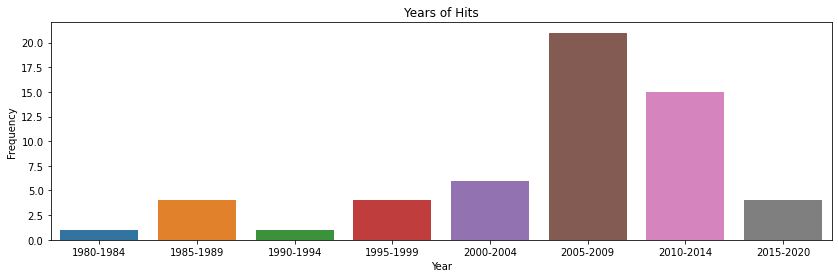

In [ ]:
# 출고량 높은 게임들 연도 시각화

plt.figure(figsize=(14, 4))
plt.title("Years of Hits")
sns.barplot(x = df_Year['Year'], y = df_Year['Frequency'])

plt.show()

In [ ]:
# 히트작 주요 플랫폼 확인

Platform_filter_3DS = Sales_1500['Platform'].str.contains('3DS')
Platform_filter_DS = Sales_1500['Platform'].str.contains('DS')
Platform_filter_GB = Sales_1500['Platform'].str.contains('GB')
Platform_filter_GBA = Sales_1500['Platform'].str.contains('GBA')
Platform_filter_GC = Sales_1500['Platform'].str.contains('GC')
Platform_filter_GEN = Sales_1500['Platform'].str.contains('GEN')
Platform_filter_N64 = Sales_1500['Platform'].str.contains('N64')
Platform_filter_NES = Sales_1500['Platform'].str.contains('NES')
Platform_filter_PC = Sales_1500['Platform'].str.contains('PC')
Platform_filter_PS = Sales_1500['Platform'].str.contains('PS')
Platform_filter_PS2 = Sales_1500['Platform'].str.contains('PS2')
Platform_filter_PS3 = Sales_1500['Platform'].str.contains('PS3')
Platform_filter_PS4 = Sales_1500['Platform'].str.contains('PS4')
Platform_filter_PSP = Sales_1500['Platform'].str.contains('PSP')
Platform_filter_PSV = Sales_1500['Platform'].str.contains('PSV')
Platform_filter_SNES = Sales_1500['Platform'].str.contains('SNES')
Platform_filter_Wii = Sales_1500['Platform'].str.contains('Wii')
Platform_filter_WiiU = Sales_1500['Platform'].str.contains('WiiU')
Platform_filter_X360 = Sales_1500['Platform'].str.contains('X360')
Platform_filter_XB = Sales_1500['Platform'].str.contains('XB')
Platform_filter_XOne = Sales_1500['Platform'].str.contains('XOne')

DS3 = len(Sales_1500[Platform_filter_3DS])
DS = len(Sales_1500[Platform_filter_DS])
GB = len(Sales_1500[Platform_filter_GB])
GBA = len(Sales_1500[Platform_filter_GBA])
GC = len(Sales_1500[Platform_filter_GC])
GEN = len(Sales_1500[Platform_filter_GEN])
N64 = len(Sales_1500[Platform_filter_N64])
NES = len(Sales_1500[Platform_filter_NES])
PC = len(Sales_1500[Platform_filter_PC])
PS = len(Sales_1500[Platform_filter_PS])
PS2 = len(Sales_1500[Platform_filter_PS2])
PS3 = len(Sales_1500[Platform_filter_PS3])
PS4 = len(Sales_1500[Platform_filter_PS4])
PSP = len(Sales_1500[Platform_filter_PSP])
PSV = len(Sales_1500[Platform_filter_PSV])
SNES = len(Sales_1500[Platform_filter_SNES])
Wii = len(Sales_1500[Platform_filter_Wii])
WiiU = len(Sales_1500[Platform_filter_WiiU])
X360 = len(Sales_1500[Platform_filter_X360])
XB = len(Sales_1500[Platform_filter_XB])
XOne = len(Sales_1500[Platform_filter_XOne])

data_Platform = {'Platform': ['3DS','DS','GB','GBA','GC','GEN','N64','NES','PC','PS','PS2','PS3','PS4','PSP','PSV','SNES','Wii','WiiU','X360','XB','XOne'],
                 'Frequency': [DS3,DS,GB,GBA,GC,GEN,N64,NES,PC,PS,PS2,PS3,PS4,PSP,PSV,SNES,Wii,WiiU,X360,XB,XOne]}
df_Platform = pd.DataFrame(data = data_Platform)
df_Platform

Platform  Frequency
0       3DS          4
1        DS         16
2        GB          8
3       GBA          3
4        GC          0
5       GEN          0
6       N64          1
7       NES          5
8        PC         19
9        PS         23
10      PS2          3
11      PS3         21
12      PS4          8
13      PSP          2
14      PSV          4
15     SNES          1
16      Wii         19
17     WiiU          4
18     X360         23
19       XB          1
20     XOne          8

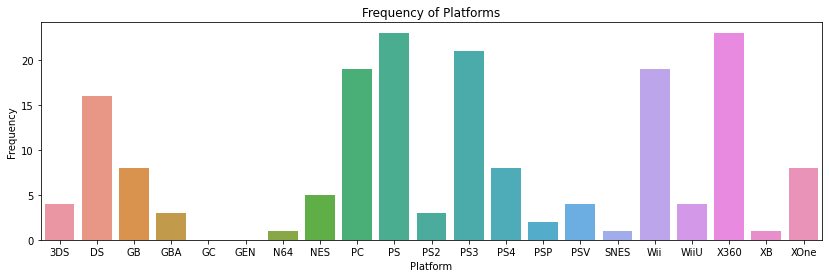

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Frequency of Platforms")
sns.barplot(x = df_Platform['Platform'], y = df_Platform['Frequency'])

plt.show()

In [ ]:
# 히트작 장르 확인

Genre_list = Sales_1500['Genre']
Genre_list = Genre_list.to_list()

Sp = Genre_list.count('Sports')
Ac = Genre_list.count('Action')
Pf = Genre_list.count('Platform')
Pz = Genre_list.count('Puzzle')
Rc = Genre_list.count('Racing')
RP = Genre_list.count('Role-Playing')
St = Genre_list.count('Shooter')
Sr = Genre_list.count('Strategy')
Mi = Genre_list.count('Misc')
Sm = Genre_list.count('Simulation')

data_Genre = {'Genre': ['Sports','Action','Platform','Puzzle','Racing','Role-Playing','Shooter','Strategy','Misc','Simulation'],
              'Frequency': [Sp,Ac,Pf,Pz,Rc,RP,St,Sr,Mi,Sm]}
df_Genre = pd.DataFrame(data = data_Genre)
df_Genre

Genre  Frequency
0        Sports          7
1        Action          6
2      Platform          7
3        Puzzle          2
4        Racing          2
5  Role-Playing          6
6       Shooter         11
7      Strategy          0
8          Misc          5
9    Simulation          2

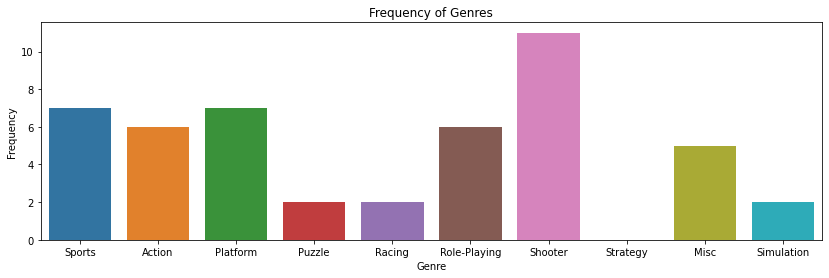

In [ ]:
plt.figure(figsize=(14, 4))
plt.title("Frequency of Genres")
sns.barplot(x = df_Genre['Genre'], y = df_Genre['Frequency'])

plt.show()